**Introduction to this Python Code File** 


1) What is the structure of the code? 
- On the left side, a list of contents is displayed. This gives a first overview and facilitates navigating through the code.


2) What do the single chapters consist of?
- The first two chapters are used for loading Python packages and defining functions that are applied in the analysis.
- In chapter 3, I define variables and parameters for the random forest algorithm. The idea of such an input mask is to concentrate most of the manual input on one code section.
- Chapter 4 then selects the data for further analyses based on the input in chapter 3.
- In chapter 5, a brief graphical overview of the selected data is given.
- Chapter 6 and chapter 7 prepare the data for its usage in the random forest algorithm. Data splitting into treatment and control group takes place in chapter 6. Splitting the data into training and test groups is done in chapter 7.
- The random forest predictions are made in chapter 8. I present results in a table format and benchmark my predictions against an OLS prediction model. 
- Chapter 9 contains more detailed analyses. Starting with the computation of the overall partial equilibrium effect, I calculate feature importances in multiple ways in section 9.2. This is followed by the calculation of the partial dependence plots in 9.3. Graphical illustrations of labor income response distributions can be found in the sections 9.4 and 9.5. 


# Load Packages

In [45]:
#### Load Packages

import pandas as pd 
import numpy as np
import math 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.api import OLS
import seaborn as sns
from rfpimp import plot_corr_heatmap
from rfpimp import permutation_importances
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.base import clone
from itertools import repeat
import probscale
from IPython.display import display_html
from scipy.stats import spearmanr
from scipy.stats import pearsonr

%matplotlib inline
sns.set_style('whitegrid');
sns.set(rc = {'figure.figsize': (18.5,15.5)});
plt.figure(figsize=(18.5,15.5));

<Figure size 1332x1116 with 0 Axes>

# Functions

In [46]:
############################################################################################################


def lag_function(lag,frame):

    ## Here, I select all the lags that I want to measure the effect in
    if lag == 'All':
        selected_lags = frame    

    else: 
        lag_over_year = []
        for i in lag: 
            lag_over_year.append(-12+i)
        frame['Is In Selected Lags'] = ((frame.month_numerical - frame.reb_month_numerical).isin(lag) | (frame.month_numerical - frame.reb_month_numerical).isin(lag_over_year))
        selected_lags = frame[frame['Is In Selected Lags'] == True]
        selected_lags = selected_lags.drop(['Is In Selected Lags'], axis = 1)
    
    return selected_lags








############################################################################################################

## Functions for Displaying several DataFrames below each other

############################################################################################################


def display_below_each_other(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:block"'),raw=True)


    
    
    
    

############################################################################################################

## Functions for the Feature Importance Section

############################################################################################################




# Create a feature importance dataframe for the default computation
def imp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    if len(feature_names_model_1) != len(feature_names_model_2): 
    
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': model_1.feature_importances_})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': model_2.feature_importances_})
        df = pd.concat([df1,df2], ignore_index=True, axis=1)
        df.columns = ['a','b','c','d']
        df.drop('a', axis = 1)
        df = df[['c','b','d']]
        df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        df = df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
        
        
    else: 
        df  = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': model_1.feature_importances_, 
                       str(name_model_2) + ' feature importance': model_2.feature_importances_}) \
                    .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
                    .reset_index(drop = True)
    
    
    return df




############################################################################################################


# Create a feature importance plot for the default computation
def feat_imp_plot(df, name_model_1, name_model_2, title):

    sns.set()
    sns.set(font_scale=1.3)
    sns.set_style("whitegrid")
    
    # importances are already sorted correctly
    importances_1 = df[str(name_model_1) +  ' feature importance']    
    importances_2 = df[str(name_model_2) +  ' feature importance']    

    names = df['Feature']                            
    group_1 = [name_model_1] * len(names)                  
    group_2 = [name_model_2] * len(names)

    data = {'feature_importance': importances_1, 'feature_name': names, 'Data Set': group_1}
    df = pd.DataFrame(data)
    data2 = {'feature_importance': importances_2, 'feature_name': names, 'Data Set': group_2}
    df2 = pd.DataFrame(data2)
    df = df.append(df2, ignore_index = True)
    df = df.sort_values(['Data Set', 'feature_importance'], ascending = (True, False))
    
    
    pl = sns.catplot(x='feature_importance', y='feature_name', hue='Data Set', data=df, orient = 'h',
                height=6, aspect=2, kind='bar', palette='Set1', linewidth = 0.3, legend_out=False)
    pl.set_ylabels('Feature Name', fontsize = 20)
    pl.set_xlabels('Feature Importance', fontsize = 20)
    plt.xticks(rotation=0, horizontalalignment='right')

    
    
############################################################################################################


# Create a feature importance dataframe for the permutation computation
def perm_imp_rfpimp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    
    control_perm_imp_rfpimp = permutation_importances(model_1, rf_control_features, 
                                                      labels, control_r2)
    control_perm_imp_rfpimp.reset_index(drop = False, inplace = True)
    
    
    treatment_perm_imp_rfpimp = permutation_importances(model_2, rf_treatment_features, 
                                                        labels, treatment_r2)
    treatment_perm_imp_rfpimp.reset_index(drop = False, inplace = True)
    
    
    if len(feature_names_model_1) != len(feature_names_model_2):  
    
        df1 = pd.DataFrame(data = control_perm_imp_rfpimp)
        df2 = pd.DataFrame(data = treatment_perm_imp_rfpimp)
    
        df = df1.merge(df2, on = 'Feature')
    
        df.append(df2)
    
        df3 = pd.DataFrame([['rebate_uplifting', np.nan, df2.iloc[len(df1),1]], ['rebate_uplifting_spend', np.nan, df2.iloc[len(df1)+1,1]], 
                      ['rebate_uplifting_save', np.nan, df2.iloc[len(df1)+2,1]], ['rebate_uplifting_debt', np.nan, df2.iloc[len(df1)+3,1]]], 
                       columns=list(['Feature', 'Importance_x', 'Importance_y']))

        df = df.append(df3, ignore_index = True)

        df.rename(columns={'Importance_x': str(name_model_1) +  ' feature importance', 
                       'Importance_y': str(name_model_2) +  ' feature importance'}, inplace = True)
        
        
    else: 
          
        df1 = pd.DataFrame(data = control_perm_imp_rfpimp)
        df2 = pd.DataFrame(data = treatment_perm_imp_rfpimp)
    
        df = df1.merge(df2, on = 'Feature')


        df.rename(columns={'Importance_x': str(name_model_1) +  ' feature importance', 
                       'Importance_y': str(name_model_2) +  ' feature importance'}, inplace = True)
    
    return df



    

############################################################################################################


# Create a feature importance dataframe for the permutation computation
def perm_imp_eli5_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2):
    
    control_perm = PermutationImportance(model_1, cv = None, refit = False, n_iter = 2). \
                                                    fit(rf_control_features, labels)
    
    treatment_perm = PermutationImportance(model_2, cv = None, refit = False, n_iter = 2). \
                                                    fit(rf_treatment_features, labels)
    

    
    if len(feature_names_model_1) != len(feature_names_model_2):
        
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': control_perm.feature_importances_})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': treatment_perm.feature_importances_})
        df = pd.concat([df1,df2], ignore_index=True, axis=1)
        df.columns = ['a','b','c','d']
        df.drop('a', axis = 1)
        df = df[['c','b','d']]
        df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        df = df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
    
    
    
    else: 
        
        df = pd.DataFrame({'Feature': feature_names_model_1, 
                      str(name_model_1) + ' feature importance': control_perm.feature_importances_, 
                      str(name_model_2) + ' feature importance': treatment_perm.feature_importances_}) \
           .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
           .reset_index(drop = True)
    
    return df    





############################################################################################################


# Define the calculation of the R2 score for the permutation feature importance

def control_r2(model_1, rf_control_features, labels): 
    return r2_score(labels, model_1.predict(rf_control_features))


def treatment_r2(model_2, rf_treatment_features, labels): 
    return r2_score(labels, model_2.predict(rf_treatment_features))




############################################################################################################




def drop_col_feat_imp(feature_names_model_1, feature_names_model_2, model_1, model_2):
    
    model_1_clone = clone(model_1)
    model_2_clone = clone(model_2)
    
    model_1_clone.random_state = random_state
    model_2_clone.random_state = random_state
    
    model_1_clone.fit(rf_control_features, labels)
    model_2_clone.fit(rf_treatment_features, labels)  
    
    benchmark_1_score = model_1_clone.score(rf_control_features, labels)
    benchmark_2_score = model_2_clone.score(rf_treatment_features, labels)
    
    importances_1 = []
    importances_2 = []

    for x in rf_control_train_features.columns:
        model_1_clone = clone(model_1)
        model_1_clone.random_state = random_state
        model_1_clone.fit(rf_control_features.drop(x,axis = 1), labels)
        drop_x_1_score = model_1_clone.score(rf_control_features.drop(x,axis = 1), labels)
        importances_1.append(benchmark_1_score - drop_x_1_score)
        
    for y in rf_treatment_train_features.columns:
        model_2_clone = clone(model_2)
        model_2_clone.random_state = random_state
        model_2_clone.fit(rf_treatment_features.drop(y,axis = 1), labels)
        drop_y_2_score = model_2_clone.score(rf_treatment_features.drop(y,axis = 1), labels)
        importances_2.append(benchmark_2_score - drop_y_2_score)
        
    
    if len(feature_names_model_1) != len(feature_names_model_2):
    
        df1 = pd.DataFrame({'Feature': feature_names_model_1, 
                       str(name_model_1) + ' feature importance': importances_1})
        df2 = pd.DataFrame({'Feature': feature_names_model_2, 
                       str(name_model_2) + ' feature importance': importances_2})
        result_df = pd.concat([df1,df2], ignore_index=True, axis=1)
        result_df.columns = ['a','b','c','d']
        result_df.drop('a', axis = 1)
        result_df = result_df[['c','b','d']]
        result_df.columns = ['Feature', str(name_model_1) + ' feature importance', str(name_model_2) + ' feature importance']
        result_df = result_df.sort_values(str(name_model_1) + ' feature importance', ascending = False).reset_index(drop = True)
    
    else: 
        result_df = pd.DataFrame({'Feature': feature_names_model_1, 
                      str(name_model_1) + ' feature importance': importances_1, 
                      str(name_model_2) + ' feature importance': importances_2}) \
           .sort_values(str(name_model_1) + ' feature importance', ascending = False) \
           .reset_index(drop = True)
    
    
    
    
    
    return result_df




############################################################################################################

## Functions for the Partial Dependence Section

############################################################################################################


def pdp_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind):
    
    # Idea PDP computation 
    # 1) Compute responses for all months
    # 2) Select specific lags afterwards (like in the original RF estimation)
    
    
    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()
    
    rebate_payment_indicator = result_months.rebate_payment
    result_months_pdp_all = result_months.copy()
    result_months_pdp_0 = result_months.copy()
    result_months_pdp_12 = result_months.copy()

    grid = np.unique(X_temp_2[:, pd_feature])
    
    
    y_diff_mean_all = np.zeros(len(grid))
    y_diff_median_all = np.zeros(len(grid))
    y_diff_perc_5_all = np.zeros(len(grid))
    y_diff_perc_25_all = np.zeros(len(grid))    
    y_diff_perc_75_all = np.zeros(len(grid))
    y_diff_perc_95_all = np.zeros(len(grid))    
    y_diff_sd_all = np.zeros(len(grid))
    
    y_diff_mean_0 = np.zeros(len(grid))
    y_diff_median_0 = np.zeros(len(grid))
    y_diff_perc_5_0 = np.zeros(len(grid))
    y_diff_perc_25_0 = np.zeros(len(grid))    
    y_diff_perc_75_0 = np.zeros(len(grid))
    y_diff_perc_95_0 = np.zeros(len(grid))    
    y_diff_sd_0 = np.zeros(len(grid))
    
    y_diff_mean_12 = np.zeros(len(grid))
    y_diff_median_12 = np.zeros(len(grid))
    y_diff_perc_5_12 = np.zeros(len(grid))
    y_diff_perc_25_12 = np.zeros(len(grid))    
    y_diff_perc_75_12 = np.zeros(len(grid))
    y_diff_perc_95_12 = np.zeros(len(grid))    
    y_diff_sd_12 = np.zeros(len(grid))
    
    
    if kind == 'Absolute': 
        unit = 'USD'
    else: 
        unit = '%'
    

    for i, value in enumerate(grid):
        
        if pd_feature in rf_control_features_list == True: 
            X_temp_1[:, pd_feature] = value
            data_1 = X_temp_1
        else: 
            data_1 = X_temp_1   
        
        if chosen_feature in (['rebate_uplifting', 'rebate_uplifting_debt', 'rebate_uplifting_spend', 'rebate_uplifting_save']): 
            # I multiply the feature value of the rebate with the indicator value of rebate reception to 
            # make sure that rebate size values are only adjusted in rows where rebates where paid for real.
            # If I did not multiply val by the rebate payment indicator, I'd simulate that rebates were paid
            # in every observation.
            X_temp_2[:, pd_feature] = value*rebate_payment_indicator 
            data_2 = X_temp_2
        else:
            X_temp_2[:, pd_feature] = value
            data_2 = X_temp_2
            
            
        pred_1 = model_1.predict(data_1) # control predictions
        pred_2 = model_2.predict(data_2) # treatment predictions
        
        diffs_pre = pred_2 - pred_1
        
        result_months_pdp_all['PDP_diff'] = diffs_pre
        result_months_pdp_0['PDP_diff'] = diffs_pre
        result_months_pdp_12['PDP_diff'] = diffs_pre
        
        # All lags
        selected_lags_all = result_months_pdp_all.copy()
        
        # Lag 0
        result_months_pdp_0['Is In Selected Lags'] = ((result_months_pdp_0.month_numerical - result_months_pdp_0.reb_month_numerical) == 0)
        selected_lags_0 = result_months_pdp_0[result_months_pdp_0['Is In Selected Lags'] == True]    
        selected_lags_0 = selected_lags_0.drop(['Is In Selected Lags'], axis = 1)    
            
        # Lag 1 and 2
        result_months_pdp_12['Is In Selected Lags'] = (((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 1) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 2) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -11) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -10))
        selected_lags_12 = result_months_pdp_12[result_months_pdp_12['Is In Selected Lags'] == True]
        selected_lags_12 = selected_lags_12.drop(['Is In Selected Lags'], axis = 1)
            
        # Select estimated labor income differences for each time period    
        diffs_all = selected_lags_all['PDP_diff']
        diffs_0 = selected_lags_0['PDP_diff']
        diffs_12 = selected_lags_12['PDP_diff']
        
        if kind == 'Absolute':
        
            y_diff_mean_all[i] = np.mean(diffs_all)
            y_diff_median_all[i] = np.median(diffs_all)
            y_diff_perc_5_all[i] = np.percentile(diffs_all, 5)
            y_diff_perc_25_all[i] = np.percentile(diffs_all, 25)
            y_diff_perc_75_all[i] = np.percentile(diffs_all, 75)
            y_diff_perc_95_all[i] = np.percentile(diffs_all, 95)
            y_diff_sd_all[i] = np.std(diffs_all)
            
            y_diff_mean_0[i] = np.mean(diffs_0)
            y_diff_median_0[i] = np.median(diffs_0)
            y_diff_perc_5_0[i] = np.percentile(diffs_0, 5)
            y_diff_perc_25_0[i] = np.percentile(diffs_0, 25)
            y_diff_perc_75_0[i] = np.percentile(diffs_0, 75)
            y_diff_perc_95_0[i] = np.percentile(diffs_0, 95)
            y_diff_sd_0[i] = np.std(diffs_0)
            
            y_diff_mean_12[i] = np.mean(diffs_12)
            y_diff_median_12[i] = np.median(diffs_12)
            y_diff_perc_5_12[i] = np.percentile(diffs_12, 5)
            y_diff_perc_25_12[i] = np.percentile(diffs_12, 25)
            y_diff_perc_75_12[i] = np.percentile(diffs_12, 75)
            y_diff_perc_95_12[i] = np.percentile(diffs_12, 95)
            y_diff_sd_12[i] = np.std(diffs_12)
        
        elif kind == 'Percentual':
            
            y_diff_mean_all[i] = np.mean(diffs_all/selected_lags_all[income_var])#*100
            y_diff_median_all[i] = np.median(diffs_all/selected_lags_all[income_var])#*100
            y_diff_perc_5_all[i] = np.percentile(diffs_all/selected_lags_all[income_var], 5)#*100
            y_diff_perc_25_all[i] = np.percentile(diffs_all/selected_lags_all[income_var], 25)#*100
            y_diff_perc_75_all[i] = np.percentile(diffs_all/selected_lags_all[income_var], 75)#*100
            y_diff_perc_95_all[i] = np.percentile(diffs_all/selected_lags_all[income_var], 95)#*100
            y_diff_sd_all[i] = np.std(diffs_all/selected_lags_all[income_var])#*100
            
            y_diff_mean_0[i] = np.mean(diffs_0/selected_lags_0[income_var])#*100
            y_diff_median_0[i] = np.median(diffs_0/selected_lags_0[income_var])#*100
            y_diff_perc_5_0[i] = np.percentile(diffs_0/selected_lags_0[income_var], 5)#*100
            y_diff_perc_25_0[i] = np.percentile(diffs_0/selected_lags_0[income_var], 25)#*100
            y_diff_perc_75_0[i] = np.percentile(diffs_0/selected_lags_0[income_var], 75)#*100
            y_diff_perc_95_0[i] = np.percentile(diffs_0/selected_lags_0[income_var], 95)#*100
            y_diff_sd_0[i] = np.std(diffs_0/selected_lags_0[income_var])#*100
            
            y_diff_mean_12[i] = np.mean(diffs_12/selected_lags_12[income_var])#*100
            y_diff_median_12[i] = np.median(diffs_12/selected_lags_12[income_var])#*100
            y_diff_perc_5_12[i] = np.percentile(diffs_12/selected_lags_12[income_var], 5)#*100
            y_diff_perc_25_12[i] = np.percentile(diffs_12/selected_lags_12[income_var], 25)#*100
            y_diff_perc_75_12[i] = np.percentile(diffs_12/selected_lags_12[income_var], 75)#*100
            y_diff_perc_95_12[i] = np.percentile(diffs_12/selected_lags_12[income_var], 95)#*100
            y_diff_sd_12[i] = np.std(diffs_12/selected_lags_12[income_var])#*100
            
        elif chosen_feature == 'rebate_uplifting': 
            
            y_diff_mean_all[i] = np.mean(diffs_all/value)#*100
            y_diff_median_all[i] = np.median(diffs_all/value)#*100
            y_diff_perc_5_all[i] = np.percentile(diffs_all/value, 5)#*100
            y_diff_perc_25_all[i] = np.percentile(diffs_all/value, 25)#*100
            y_diff_perc_75_all[i] = np.percentile(diffs_all/value, 75)#*100
            y_diff_perc_95_all[i] = np.percentile(diffs_all/value, 95)#*100
            y_diff_sd_all[i] = np.std(diffs_all/value)#*100
            
            y_diff_mean_0[i] = np.mean(diffs_0/value)#*100
            y_diff_median_0[i] = np.median(diffs_0/value)#*100
            y_diff_perc_5_0[i] = np.percentile(diffs_0/value, 5)#*100
            y_diff_perc_25_0[i] = np.percentile(diffs_0/value, 25)#*100
            y_diff_perc_75_0[i] = np.percentile(diffs_0/value, 75)#*100
            y_diff_perc_95_0[i] = np.percentile(diffs_0/value, 95)#*100
            y_diff_sd_0[i] = np.std(diffs_0/value)#*100
            
            y_diff_mean_12[i] = np.mean(diffs_12/value)#*100
            y_diff_median_12[i] = np.median(diffs_12/value)#*100
            y_diff_perc_5_12[i] = np.percentile(diffs_12/value, 5)#*100
            y_diff_perc_25_12[i] = np.percentile(diffs_12/value, 25)#*100
            y_diff_perc_75_12[i] = np.percentile(diffs_12/value, 75)#*100
            y_diff_perc_95_12[i] = np.percentile(diffs_12/value, 95)#*100
            y_diff_sd_12[i] = np.std(diffs_12/value)#*100
                                         
        else:
            
            y_diff_mean_all[i] = np.mean(diffs_all/selected_lags_all.reb_size)#*100
            y_diff_median_all[i] = np.median(diffs_all/selected_lags_all.reb_size)#*100
            y_diff_perc_5_all[i] = np.percentile(diffs_all/selected_lags_all.reb_size, 5)#*100
            y_diff_perc_25_all[i] = np.percentile(diffs_all/selected_lags_all.reb_size, 25)#*100
            y_diff_perc_75_all[i] = np.percentile(diffs_all/selected_lags_all.reb_size, 75)#*100
            y_diff_perc_95_all[i] = np.percentile(diffs_all/selected_lags_all.reb_size, 95)#*100
            y_diff_sd_all[i] = np.std(diffs_all/selected_lags_all.reb_size)#*100
            
            y_diff_mean_0[i] = np.mean(diffs_0/selected_lags_0.reb_size)#*100
            y_diff_median_0[i] = np.median(diffs_0/selected_lags_0.reb_size)#*100
            y_diff_perc_5_0[i] = np.percentile(diffs_0/selected_lags_0.reb_size, 5)#*100
            y_diff_perc_25_0[i] = np.percentile(diffs_0/selected_lags_0.reb_size, 25)#*100
            y_diff_perc_75_0[i] = np.percentile(diffs_0/selected_lags_0.reb_size, 75)#*100
            y_diff_perc_95_0[i] = np.percentile(diffs_0/selected_lags_0.reb_size, 95)#*100
            y_diff_sd_0[i] = np.std(diffs_0/selected_lags_0.reb_size)#*100
            
            y_diff_mean_12[i] = np.mean(diffs_12/selected_lags_12.reb_size)#*100
            y_diff_mean_12[i] = np.mean(diffs_12/selected_lags_12.reb_size)#*100
            y_diff_median_12[i] = np.median(diffs_12/selected_lags_12.reb_size)#*100
            y_diff_perc_5_12[i] = np.percentile(diffs_12/selected_lags_12.reb_size, 5)#*100
            y_diff_perc_25_12[i] = np.percentile(diffs_12/selected_lags_12.reb_size, 25)#*100
            y_diff_perc_75_12[i] = np.percentile(diffs_12/selected_lags_12.reb_size, 75)#*100
            y_diff_perc_95_12[i] = np.percentile(diffs_12/selected_lags_12.reb_size, 95)#*100
            y_diff_sd_12[i] = np.std(diffs_12/selected_lags_12.reb_size)#*100
            
        result_months_pdp_all = result_months_pdp_all.drop(['PDP_diff'], axis = 1)     
        result_months_pdp_0 = result_months_pdp_0.drop(['PDP_diff'], axis = 1)     
        result_months_pdp_12 = result_months_pdp_12.drop(['PDP_diff'], axis = 1)     
                
    # Create the resulting dataframes that contain statistics for each time period
    
    result_table_all = pd.DataFrame({chosen_feature: grid,
                            'Mean '+str(kind)+' Difference': y_diff_mean_all, 
                            'Median '+str(kind)+' Difference': y_diff_median_all, 
                            '5th Percentile '+str(kind)+' Difference': y_diff_perc_5_all,     
                            '25th Percentile '+str(kind)+' Difference': y_diff_perc_25_all,
                            '75th Percentile '+str(kind)+' Difference': y_diff_perc_75_all,
                            '95th Percentile '+str(kind)+' Difference': y_diff_perc_95_all,                                 
                            'Standard Deviation '+str(kind)+' Difference': y_diff_sd_all}).set_index(chosen_feature)
    
    
    result_table_0 = pd.DataFrame({chosen_feature: grid,
                            'Mean '+str(kind)+' Difference': y_diff_mean_0, 
                            'Median '+str(kind)+' Difference': y_diff_median_0, 
                            '5th Percentile '+str(kind)+' Difference': y_diff_perc_5_0,     
                            '25th Percentile '+str(kind)+' Difference': y_diff_perc_25_0,
                            '75th Percentile '+str(kind)+' Difference': y_diff_perc_75_0,
                            '95th Percentile '+str(kind)+' Difference': y_diff_perc_95_0,                                 
                            'Standard Deviation '+str(kind)+' Difference': y_diff_sd_0}).set_index(chosen_feature)
    
    
    result_table_12 = pd.DataFrame({chosen_feature: grid,
                            'Mean '+str(kind)+' Difference': y_diff_mean_12, 
                            'Median '+str(kind)+' Difference': y_diff_median_12, 
                            '5th Percentile '+str(kind)+' Difference': y_diff_perc_5_12,     
                            '25th Percentile '+str(kind)+' Difference': y_diff_perc_25_12,
                            '75th Percentile '+str(kind)+' Difference': y_diff_perc_75_12,
                            '95th Percentile '+str(kind)+' Difference': y_diff_perc_95_12,                                 
                            'Standard Deviation '+str(kind)+' Difference': y_diff_sd_12}).set_index(chosen_feature)

    return result_table_all, result_table_0, result_table_12


############################################################################################################


def pdp_plot(df, measure, kind, lags):
    
    if kind == 'Absolute': 
        unit = 'USD'
        y = df[str(measure) +' '+ str(kind) +' Difference']
    else: 
        unit = '%'
        y = df[str(measure) +' '+ str(kind) +' Difference']*100 
  
    x = df.index

    result_months_pdp_all = result_months.copy()
    result_months_pdp_0 = result_months.copy()
    result_months_pdp_12 = result_months.copy()
    
    # All lags
    selected_lags_all = result_months_pdp_all.copy()
        
    # Lag 0
    result_months_pdp_0['Is In Selected Lags'] = ((result_months_pdp_0.month_numerical - result_months_pdp_0.reb_month_numerical) == 0)
    selected_lags_0 = result_months_pdp_0[result_months_pdp_0['Is In Selected Lags'] == True]    
    selected_lags_0 = selected_lags_0.drop(['Is In Selected Lags'], axis = 1)    
            
    # Lag 1 and 2
    result_months_pdp_12['Is In Selected Lags'] = (((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 1) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 2) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -11) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -10))
    selected_lags_12 = result_months_pdp_12[result_months_pdp_12['Is In Selected Lags'] == True]
    selected_lags_12 = selected_lags_12.drop(['Is In Selected Lags'], axis = 1)
    
    if lags == 'All': 
        chosen_lags = selected_lags_all
    elif lags == [0]: 
        chosen_lags = selected_lags_0
    else: 
        chosen_lags = selected_lags_12
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)})
    fig.set_size_inches(18.5, 15.5)
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    

    # Add a graph in each part
    sns.boxplot(chosen_lags[chosen_feature], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    
    if len(x) < 5: 
        ax_pdp.plot(x, y, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+10*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
        
    
    else:
        ax_pdp.plot(x, y, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(y)-abs(0.2*min(y)), max(y)+0.2*abs(max(y))])
        ax_pdp.set(xlabel = chosen_feature, ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        

   ############################################################################################################


def partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred = [], f_plot = -1):
    
    # Same idea like in function pdp_plot
    # Here, I do not store estimates as dataframe
    # I only save mean and median in order to plot them immediately as partial dependence plot

    X_temp_1 = X_1.copy()
    X_temp_2 = X_2.copy()
    
    rebate_payment_indicator = result_months.rebate_payment
    result_months_pdp_all = result_months.copy()
    result_months_pdp_0 = result_months.copy()
    result_months_pdp_12 = result_months.copy()
        
    grid = np.unique(X_temp_2[:, f_plot])
    
    y_diff_mean_all = np.zeros(len(grid))
    y_diff_median_all = np.zeros(len(grid))
    
    y_diff_mean_0 = np.zeros(len(grid))
    y_diff_median_0 = np.zeros(len(grid))
    
    y_diff_mean_12 = np.zeros(len(grid))
    y_diff_median_12 = np.zeros(len(grid))
    
    
    if len(feature_pred) == 0 or f_plot == -1:
        print('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            
            if f in rf_control_features_list == True:
            
                X_temp_1[:, f_plot] = val
                data_1 = X_temp_1
            else: 
                data_1 = X_temp_1

            
            if f in (['rebate_uplifting', 'rebate_uplifting_debt', 'rebate_uplifting_spend', 'rebate_uplifting_save']): 
                # I multiply the feature value of the rebate with the indicator value of rebate reception to 
                # make sure that rebate size values are only adjusted in rows where rebates where paid for real.
                # If I did not multiply val by the rebate payment indicator, I'd simulate that rebates were paid
                # in every observation.
                X_temp_2[:, f_plot] = val*rebate_payment_indicator 
                data_2 = X_temp_2
            else:
                X_temp_2[:, f_plot] = val # for features not linked to rebate characteristics, I don't need this selection
                data_2 = X_temp_2
                
                
            
            pred_1 = model_1.predict(data_1) # control predictions
            pred_2 = model_2.predict(data_2) # treatment predictions
        
            diffs_pre = pred_2 - pred_1
        
            result_months_pdp_all['PDP_diff'] = diffs_pre
            result_months_pdp_0['PDP_diff'] = diffs_pre
            result_months_pdp_12['PDP_diff'] = diffs_pre
            
            
            # All lags
            selected_lags_all = result_months_pdp_all.copy()
        
            # Lag 0
            result_months_pdp_0['Is In Selected Lags'] = ((result_months_pdp_0.month_numerical - result_months_pdp_0.reb_month_numerical) == 0)
            selected_lags_0 = result_months_pdp_0[result_months_pdp_0['Is In Selected Lags'] == True]    
            selected_lags_0 = selected_lags_0.drop(['Is In Selected Lags'], axis = 1)    
            
            # Lag 1 and 2
            result_months_pdp_12['Is In Selected Lags'] = (((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 1) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == 2) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -11) | ((result_months_pdp_12.month_numerical - result_months_pdp_12.reb_month_numerical) == -10))
            selected_lags_12 = result_months_pdp_12[result_months_pdp_12['Is In Selected Lags'] == True]
            selected_lags_12 = selected_lags_12.drop(['Is In Selected Lags'], axis = 1)
            
            diffs_all = selected_lags_all['PDP_diff']
            diffs_0 = selected_lags_0['PDP_diff']
            diffs_12 = selected_lags_12['PDP_diff']
            
            
            
            if kind == 'Absolute':
                y_diff_mean_all[i] = np.mean(diffs_all)
                y_diff_median_all[i] = np.median(diffs_all)
                
                y_diff_mean_0[i] = np.mean(diffs_0)
                y_diff_median_0[i] = np.median(diffs_0)
                
                y_diff_mean_12[i] = np.mean(diffs_12)
                y_diff_median_12[i] = np.median(diffs_12)
    
            elif kind == 'Percentual':
                y_diff_mean_all[i] = np.mean(diffs_all/selected_lags_all[income_var])*100
                y_diff_median_all[i] = np.median(diffs_all/selected_lags_all[income_var])*100
                
                y_diff_mean_0[i] = np.mean(diffs_0/selected_lags_0[income_var])*100
                y_diff_median_0[i] = np.median(diffs_0/selected_lags_0[income_var])*100
                
                y_diff_mean_12[i] = np.mean(diffs_12/selected_lags_12[income_var])*100
                y_diff_median_12[i] = np.median(diffs_12/selected_lags_12[income_var])*100
    
            elif f == 'rebate_uplifting': 
            
                y_diff_mean_all[i] = np.mean(diffs_all/val)*100
                y_diff_median_all[i] = np.median(diffs_all/val)*100
            
                y_diff_mean_0[i] = np.mean(diffs_0/val)*100
                y_diff_median_0[i] = np.median(diffs_0/val)*100
            
                y_diff_mean_12[i] = np.mean(diffs_12/val)*100
                y_diff_median_12[i] = np.median(diffs_12/val)*100
                
            else:    
                y_diff_mean_all[i] = np.mean(diffs_all/selected_lags_all.reb_size)*100
                y_diff_median_all[i] = np.median(diffs_all/selected_lags_all.reb_size)*100
                
                y_diff_mean_0[i] = np.mean(diffs_0/selected_lags_0.reb_size)*100
                y_diff_median_0[i] = np.median(diffs_0/selected_lags_0.reb_size)*100
                
                y_diff_mean_12[i] = np.mean(diffs_12/selected_lags_12.reb_size)*100
                y_diff_median_12[i] = np.median(diffs_12/selected_lags_12.reb_size)*100
            
    
    
    return grid, y_diff_mean_all, y_diff_median_all, y_diff_mean_0, y_diff_median_0, y_diff_mean_12, y_diff_median_12, selected_lags_all, selected_lags_0, selected_lags_12




############################################################################################################


def mean_percentile(data, measure, kind, nth_value, n_quantile, plot1, plot2):
    
    ## Idea: First, I compute the mean reduction for every reported labor income, then I plot it as a graph
    
    inc_dist = pd.DataFrame({'Household ID': data.ssuid,
                         'Month': data.month,
                         'Year': data.year,
                         'Reported Monthly Labor Income': data[income_var],
                         'Mean Labor Income': data[income_var_mean],
                         'Labor Income Ratio': data.labor_income_ratio,
                         'Date of Rebate Payment': data.reb_month,
                         'Rebate Size': data.reb_size,
                         'Treatment Group Prediction': data.rf_treatment_predictions,
                         'Control Group Prediction': data.rf_control_predictions,
                         'Absolute Change in Labor Income due to the Rebate Payment': data.rf_labor_income_diff, 
                         'Percentual Change in Labor Income due to the Rebate Payment': data.rf_perc_labor_income_diff*100,
                         'Marginal Change in Labor Income due to the Rebate Payment': data.rf_marg_labor_income_diff*100}).reset_index(drop = True)

    ## Select all labor income changes
    df = inc_dist.copy()
    
    if measure == 'Mean': 
        df[str(measure) + ' '+str(kind)+' Change per Labor Income Level'] = df.groupby('Reported Monthly Labor Income')[str(kind)+' Change in Labor Income due to the Rebate Payment'].transform('mean')
    else: 
        df[str(measure) + ' '+str(kind)+' Change per Labor Income Level'] = df.groupby('Reported Monthly Labor Income')[str(kind)+' Change in Labor Income due to the Rebate Payment'].transform('median')

    x = df.loc[:: nth_value, 'Reported Monthly Labor Income']
    y = df.loc[:: nth_value, str(kind)+' Change in Labor Income due to the Rebate Payment']


    ## Select the mean change in labor income for every income level
    df_new = df[['Reported Monthly Labor Income', str(measure) + ' '+str(kind)+' Change per Labor Income Level']].sort_values('Reported Monthly Labor Income', ascending = True)
    df_new.drop_duplicates(subset = 'Reported Monthly Labor Income', 
                     keep = 'first', inplace = True)

    x_2 = df_new.loc[:: nth_value, 'Reported Monthly Labor Income']
    y_2 = df_new.loc[:: nth_value, str(measure) + ' '+str(kind)+' Change per Labor Income Level']

    #########################################################################################
    
    if kind == 'Absolute': 
        unit = 'USD'
        y_high = 500
        y_low = -500
    elif kind == 'Percentual': 
        unit = '%'
        y_high = 20
        y_low = -20
    else: 
        unit = '%'
        y_high = 50
        y_low = -50
    
    ## First Plot
  
    if plot1 == True:
    
        position, change_plot = probscale.plot_pos(df_new[str(measure) + ' '+str(kind)+' Change per Labor Income Level'])
        position *= 100
        fig, ax = plt.subplots(figsize=(18.5,15.5))
        ax.plot(position, change_plot, marker='.', linestyle='none', label= str(kind)+' Labor Income Change')
        ax.set_xlabel('Percentiles of ' + str(measure)+ ' '+str(kind)+' Labor Income Change', fontsize = 30)
        ax.set_ylabel(str(measure) + ' '+str(kind)+' Labor Income Change (' + str(unit) + ')', fontsize = 30)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.set_facecolor('white')
        ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax.tick_params(labelsize=30)
        plt.axis([min(position)-0.05, max(position)+0.05, y_low, y_high])
        plt.hlines(0,xmin=0,xmax =100, colors='black', linestyles='--', alpha = 1)
        sns.despine()
        plt.show()
    
    else: 
        unit = unit
    #########################################################################################
   
   
    # Mean Change in Labor Income for Income Percentiles

    percentiles = np.linspace(0, 100, len(df_new['Reported Monthly Labor Income']))

    b = pd.DataFrame({'Reported Monthly Labor Income': df_new['Reported Monthly Labor Income'], 
                      'Percentile': percentiles,
                      str(measure) + ' '+str(kind)+' Change per Labor Income Level': df_new[str(measure) + ' '+str(kind)+' Change per Labor Income Level']}) \
                      .reset_index(drop=True)

    x = b.loc[:: nth_value, 'Percentile']
    y = b.loc[:: nth_value, str(measure) + ' '+str(kind)+' Change per Labor Income Level']
    
    
    # Compute the mean and median values for each quantile that will be displayed as blue line in the graph later
    quantiles = []
    values = np.arange(0,101,100/n_quantile).tolist()

    if measure == 'Mean': 
    
        for i in values: 
   
            if values.index(i) == 0:

                quantiles.append(np.repeat(b[(b.Percentile >= i) & (b.Percentile <= (i+(100/n_quantile)))][str(measure) + ' '+str(kind)+' Change per Labor Income Level'].mean(), len(b[(b.Percentile >= i) & (b.Percentile <= (i+(100/n_quantile)))]))) 

            elif  values.index(i) < n_quantile:
        
                quantiles.append(np.repeat(b[(b.Percentile > i) & (b.Percentile <= (i+(100/n_quantile)))][str(measure) + ' '+str(kind)+' Change per Labor Income Level'].mean(), len(b[(b.Percentile > i) & (b.Percentile <= (i+(100/n_quantile)))]))) 
            
            else:    
                quantiles = quantiles
    
    else: 
        for i in values: 
   
            if values.index(i) == 0:

                quantiles.append(np.repeat(b[(b.Percentile >= i) & (b.Percentile <= (i+(100/n_quantile)))][str(measure) + ' '+str(kind)+' Change per Labor Income Level'].median(), len(b[(b.Percentile >= i) & (b.Percentile <= (i+(100/n_quantile)))]))) 

            elif  values.index(i) < n_quantile:
        
                quantiles.append(np.repeat(b[(b.Percentile > i) & (b.Percentile <= (i+(100/n_quantile)))][str(measure) + ' '+str(kind)+' Change per Labor Income Level'].median(), len(b[(b.Percentile > i) & (b.Percentile <= (i+(100/n_quantile)))]))) 
            
            else:    
                quantiles = quantiles
      
    
    b[str(measure) + ' '+str(kind)+' Change Quantiles'] = np.concatenate(quantiles[0:n_quantile], axis = 0)
    
    z = b.loc[:: nth_value, str(measure) + ' '+str(kind)+' Change Quantiles']

    if plot2 == True:

        ## Second Plot
    
        ## Plot the graph
  
        fig, ax = plt.subplots(figsize=(18.5,15.5))
        ax.plot(x, y, 'o', color = 'red', linewidth = 0.25, label = str(measure) + ' '+str(kind)+' Change per Labor Income Level', alpha = 0.5)
        ax.plot(x, z, '-', color = 'blue', linewidth = 2.5, label = 'Quantile ' + str(measure) + ' '+str(kind)+' Change per Labor Income Level', alpha = 0.75)
        ax.set_xlabel('Labor Income Percentile', fontsize = 50)
        ax.set_ylabel('Change in ' + str(unit), fontsize = 50)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.set_facecolor('white')
        ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax.set_xticks(np.arange(0,101,100/n_quantile))
        ax.tick_params(labelsize=40)
        plt.axis([min(x)-0.05, 100, y_low, y_high])
        plt.hlines(0, xmin = min(x), xmax= max(x), colors='black', linestyles='--', alpha = 1)
        plt.legend(loc='upper right', prop={'size': 30})
        plt.savefig('Quantile Change ' + str(measure) + ' ' + str(kind) + ' Lag ' + str(lag) + '.png')
        plt.show()
    
        quantile_result = pd.DataFrame({'Quantile': list(range(1, n_quantile+1)),
                                str(measure) + ' '+str(kind)+' Change in Labor Income (' + str(unit) + ')': z.unique()}) \
                                .set_index('Quantile')
    
    else: 
        
        quantile_result = pd.DataFrame({'Quantile': list(range(1, n_quantile+1)),
                                str(measure) + ' '+str(kind)+' Change in Labor Income (' + str(unit) + ')': z.unique()}) \
                                .set_index('Quantile')
    
    return quantile_result,b


# Define Variables and Parameters

In [47]:
#### Define the key variables

## Income Variable
income_var = 'tfearn'
income_var_mean = 'tfearn_mean'
initial_dataset = 'Cleaned_Data_Household.csv'
lag = 'All'



#### Set parameters for household selection
exclude_zero_labor_income = True # True excludes households with 0 labor income from the following analysis
exclusion_percentile = [5,95] # excludes upper and lower percentiles of the income distribution
upper_income_bound = None 
lower_income_bound = None
max_ratio = 1.5# maximum ratio between monthly reported labor income and average labor income over 8 month
                # households with ratio values higher than the parameter set or lower than 1 divided by the parameter set 
                # will be excluded
rebate_only = False # if True, then households with no rebate payment in the dataset will be excluded from the analysis
                    # if False, then households with no rebate payment in the dataset will be in the control group exclusively
                    # code for this exclusion option is in the section 'Uplifting'
        
rebate_observable = False # if True, then households are excluded if their rebate reception months is prior to their first observation months
        
max_famsize = 6 # select the maximum famsize for my calculation

    
######################################################################################################################


#### Set parameters for random forest algorithms
n_est = 10000 # number of trees
r_s = 0 # random state
m_d = 5 # maximum depth
feat = 'sqrt' # splitting feature setting
oob_score = True # oob score setting
bootstrap = True # bootstrap setting

# Further Household Selection for the Prediction Models

In [48]:
#### Select households for the prediction models
pd.set_option("display.max_columns", 80)


### 
original = pd.read_csv('Cleaned_Data_Household.csv')

final_data = original.copy()


#################################################################################################################






#### Exclude households with zero labor income

if exclude_zero_labor_income == True:
    zero_income = final_data[final_data[income_var] == 0]
    households_zero_income = zero_income.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_zero_income)]
    print(f"Due to the zero income household exclusion setting, {len(households_zero_income)} households with a reported labor income of 0 are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data

    
#### I exclude households with number of persons bigger than a specific value

if max_famsize != None:
    extreme_fam = final_data[final_data.famsize > max_famsize] \
                     .reset_index(drop = True)
    households_extreme_fam = extreme_fam.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_extreme_fam)]
    print(f"Due to the exclusion of households with {max_famsize+1} or more people, {len(households_extreme_fam)} households are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data    

    


#### I set an upper income bound for the analysis
    
if upper_income_bound != None:
    upper_bound = final_data[final_data[income_var] > upper_income_bound]
    households_upper = upper_bound.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_upper)]
    print(f"Due to the upper income bound of {upper_income_bound} US Dollars, {len(households_upper)} households are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data
    
    
#### I set a lower income bound for the analysis
    
if lower_income_bound != None:
    lower_bound = final_data[final_data[income_var] < lower_income_bound]
    households_lower = lower_bound.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_lower)]
    print(f"Due to the lower income bound of {lower_income_bound} US Dollars, {len(households_lower)} households are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data
            
    
    
#### I exclude outliers on the lower and upper end of the income distribution

if exclusion_percentile != None:
    extreme = final_data[(final_data[income_var] < np.percentile(final_data[income_var],exclusion_percentile[0])) | 
                     (final_data[income_var] > np.percentile(final_data[income_var],exclusion_percentile[1]))] \
                     .reset_index(drop = True)
    households_extreme = extreme.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_extreme)]
    print(f"Due to the outliers exclusion of {exclusion_percentile} %, {len(households_extreme)} households are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data



        
#### I set a maximum income ratio for the analysis

if max_ratio != None: 

    excl_ratio = [1/max_ratio,max_ratio] # NOT SYMMETRIC AROUND 1 !!!!
    extreme_2 = final_data[((final_data.labor_income_ratio > 0) & (final_data.labor_income_ratio < excl_ratio[0])) | (final_data.labor_income_ratio > excl_ratio[1])] \
            .reset_index(drop = True)
    households_extreme_2 = extreme_2.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_extreme_2)]
    print(f"Due to the maximum income ratio of {max_ratio}, {len(households_extreme_2)} households are excluded from the analysis.")
    print('\v')
else: 
    final_data = final_data


    
    

#### Option to exclude households with 0 rebate from the uplift modeling

if rebate_only == True:
    no_rebate = final_data[final_data.reb_receipt == 0]
    households_no_rebate = no_rebate.ssuid.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_no_rebate)]
    print(f"{len(households_no_rebate)} households, which do not receive any rebate at all, are excluded from the analysis.  Thus, every household, which receives the rebate in a month in which it is observed, is represented once in the Treatment Group and seven times in the Control Group.")
else: 
    final_data = final_data
    print(f"Households receiving no rebates in the observation months are still in the dataset. Thus, in the Control Group for the uplift modeling there are households with no rebate receivement at all.")

    
print('\v')    
#### Option to exclude households with rebate in month before first observation months

if rebate_observable == True:
    a = final_data.groupby('ssuid').mean()
    no_rebate_observable = a[(a.reb_receipt != 0) & (a.rebate_payment == 0)]
    households_no_rebate_observable = no_rebate_observable.index.unique()
    final_data = final_data[~final_data['ssuid'].isin(households_no_rebate_observable)]
    print(f"{len(households_no_rebate_observable)} households, whose rebate payment cannot be observed in the sample, are excluded from the analysis.  Thus, every household, which receives the rebate in a month in which it is observed, is represented once in the Treatment Group and seven times in the Control Group.")
else: 
    final_data = final_data
    print(f"Households receiving rebates prior to their first observation month are still in the dataset. Thus, in the Control Group for the uplift modeling there are households with early rebate receptions.")

print('\v')       

    
    
    

print(f"There are {len(final_data)} observations from {len(final_data.ssuid.unique())} households in the cleaned dataset. \nThe minimum labor income in the cleaned dataset is {min(final_data[income_var])} US Dollars. \nThe maximum labor income in the cleaned dataset is {max(final_data[income_var])} US Dollars.")
print('\v')

if final_data.groupby('ssuid').count().swave.min() == final_data.groupby('ssuid').count().swave.max() == 8:
    print(f"Every household reports 8 observations.")
else: 
    print(f"Not every household reports 8 observations.")
    
print('\v')
print(f"Due to the chosen exclusion settings, {len(original.ssuid.unique())-len(final_data.ssuid.unique())} households are excluded from the analysis.")    

Due to the zero income household exclusion setting, 4357 households with a reported labor income of 0 are excluded from the analysis.

Due to the exclusion of households with 7 or more people, 406 households are excluded from the analysis.

Due to the outliers exclusion of [5, 95] %, 3070 households are excluded from the analysis.

Due to the maximum income ratio of 1.5, 2148 households are excluded from the analysis.

Households receiving no rebates in the observation months are still in the dataset. Thus, in the Control Group for the uplift modeling there are households with no rebate receivement at all.

Households receiving rebates prior to their first observation month are still in the dataset. Thus, in the Control Group for the uplift modeling there are households with early rebate receptions.

There are 102904 observations from 12863 households in the cleaned dataset. 
The minimum labor income in the cleaned dataset is 1100 US Dollars. 
The maximum labor income in the clea

# Data Summary for the selected data

## Summary Statistics

In [49]:
#### Reproducing Table 2 from Powell


################################ Full Sample ################################

# Number of households in the sample
number_households = len(final_data.ssuid.unique())

# Household types
singles = len(final_data[final_data.spouse == 0].ssuid.unique())
married = len(final_data[final_data.spouse == 1].ssuid.unique())

# Family size
family_size_singles = final_data[final_data.spouse == 0].famsize.mean()
family_size_married = final_data[final_data.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles = final_data[final_data.spouse == 0].reb_receipt.mean() * 100
received_rebate_married = final_data[final_data.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles = final_data[final_data.spouse == 0].reb_size.sum() / final_data[final_data.spouse == 0].reb_receipt.sum()
average_rebate_married = final_data[final_data.spouse == 1].reb_size.sum() / final_data[final_data.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'tfearn' feature
no_earnings_singles = final_data[(final_data.spouse == 0) & (final_data[income_var] == 0)][income_var].count() / final_data[final_data.spouse == 0][income_var].count() * 100
no_earnings_married = final_data[(final_data.spouse == 1) & (final_data[income_var] == 0)][income_var].count() / final_data[final_data.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles = final_data[final_data.spouse == 0][income_var].quantile(0.25)
percentile_25_married = final_data[final_data.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles = final_data[final_data.spouse == 0][income_var].median()
median_married = final_data[final_data.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles = final_data[final_data.spouse == 0][income_var].quantile(0.75)
percentile_75_married = final_data[final_data.spouse == 1][income_var].quantile(0.75)


################################ Rebate Receiving Sample ################################

rebate_receiving_sample = final_data[final_data.reb_receipt == 1]

# Number of households in the sample
number_households_rebate = len(rebate_receiving_sample.ssuid.unique())

# Household types
singles_rebate = len(rebate_receiving_sample[rebate_receiving_sample.spouse == 0].ssuid.unique())
married_rebate = len(rebate_receiving_sample[rebate_receiving_sample.spouse == 1].ssuid.unique())

# Family size
family_size_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].famsize.mean()
family_size_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_size.sum() / rebate_receiving_sample[rebate_receiving_sample.spouse == 0].reb_receipt.sum()
average_rebate_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_size.sum() / rebate_receiving_sample[rebate_receiving_sample.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'tfearn' feature
no_earnings_singles_rebate = rebate_receiving_sample[(rebate_receiving_sample.spouse == 0) & (rebate_receiving_sample[income_var] == 0)][income_var].count() / rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].count() * 100
no_earnings_married_rebate = rebate_receiving_sample[(rebate_receiving_sample.spouse == 1) & (rebate_receiving_sample[income_var] == 0)][income_var].count() / rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].quantile(0.25)
percentile_25_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].median()
median_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 0][income_var].quantile(0.75)
percentile_75_married_rebate = rebate_receiving_sample[rebate_receiving_sample.spouse == 1][income_var].quantile(0.75)

################################ Received Rebate in April/May ################################

rebate_april_may = rebate_receiving_sample[(rebate_receiving_sample.reb4 == 1) | (rebate_receiving_sample.reb5 == 1)]

# Number of households in the sample
number_households_aprilmay = len(rebate_april_may.ssuid.unique())

# Household types
singles_aprilmay = len(rebate_april_may[rebate_april_may.spouse == 0].ssuid.unique())
married_aprilmay = len(rebate_april_may[rebate_april_may.spouse == 1].ssuid.unique())

# Family size
family_size_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].famsize.mean()
family_size_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0].reb_size.sum() / rebate_april_may[rebate_april_may.spouse == 0].reb_receipt.sum()
average_rebate_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1].reb_size.sum() / rebate_april_may[rebate_april_may.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'totearn' feature
no_earnings_singles_aprilmay = rebate_april_may[(rebate_april_may.spouse == 0) & (rebate_april_may[income_var] == 0)][income_var].count() / rebate_april_may[rebate_april_may.spouse == 0][income_var].count() * 100
no_earnings_married_aprilmay = rebate_april_may[(rebate_april_may.spouse == 1) & (rebate_april_may[income_var] == 0)][income_var].count() / rebate_april_may[rebate_april_may.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].quantile(0.25)
percentile_25_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].median()
median_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_aprilmay = rebate_april_may[rebate_april_may.spouse == 0][income_var].quantile(0.75)
percentile_75_married_aprilmay = rebate_april_may[rebate_april_may.spouse == 1][income_var].quantile(0.75)


################################ Received Rebate in August-December ################################

rebate_august_december = rebate_receiving_sample[(rebate_receiving_sample.reb8 == 1) | (rebate_receiving_sample.reb9 == 1)
                                                | (rebate_receiving_sample.reb10 == 1) | (rebate_receiving_sample.reb11 == 1) 
                                                | (rebate_receiving_sample.reb12 == 1)]

# Number of households in the sample
number_households_augdec = len(rebate_august_december.ssuid.unique())

# Household types
singles_augdec = len(rebate_august_december[rebate_august_december.spouse == 0].ssuid.unique())
married_augdec = len(rebate_august_december[rebate_august_december.spouse == 1].ssuid.unique())

# Family size
family_size_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].famsize.mean()
family_size_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].famsize.mean()

# Received Rebate (%)
received_rebate_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].reb_receipt.mean() * 100
received_rebate_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].reb_receipt.mean() * 100 

# Average rebate size in $ (conditional on receipt)
average_rebate_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0].reb_size.sum() / rebate_august_december[rebate_august_december.spouse == 0].reb_receipt.sum()
average_rebate_married_augdec = rebate_august_december[rebate_august_december.spouse == 1].reb_size.sum() / rebate_august_december[rebate_august_december.spouse == 1].reb_receipt.sum()

# No monthly labor earnings (%) --> 'totearn' feature
no_earnings_singles_augdec = rebate_august_december[(rebate_august_december.spouse == 0) & (rebate_august_december[income_var] == 0)][income_var].count() / rebate_august_december[rebate_august_december.spouse == 0][income_var].count() * 100
no_earnings_married_augdec = rebate_august_december[(rebate_august_december.spouse == 1) & (rebate_august_december[income_var] == 0)][income_var].count() / rebate_august_december[rebate_august_december.spouse == 1][income_var].count() * 100

# 25th percentile monthly labor earnings
percentile_25_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].quantile(0.25)
percentile_25_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].quantile(0.25)

# Median monthly labor earnings
median_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].median()
median_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].median()

# 75th percentile monthly labor earnings
percentile_75_singles_augdec = rebate_august_december[rebate_august_december.spouse == 0][income_var].quantile(0.75)
percentile_75_married_augdec = rebate_august_december[rebate_august_december.spouse == 1][income_var].quantile(0.75)



# Arrange the statistics in a table like format
table = pd.DataFrame([[round(family_size_singles, 2), round(family_size_married, 2), round(family_size_singles_rebate, 2), round(family_size_married_rebate, 2), round(family_size_singles_aprilmay, 2), round(family_size_married_aprilmay, 2), round(family_size_singles_augdec, 2), round(family_size_married_augdec, 2)], 
                      [round(received_rebate_singles, 1), round(received_rebate_married, 1), round(received_rebate_singles_rebate, 1), round(received_rebate_married_rebate, 1), round(received_rebate_singles_aprilmay, 1), round(received_rebate_married_aprilmay, 1), round(received_rebate_singles_augdec, 1), round(received_rebate_married_augdec, 1)],
                      [round(average_rebate_singles, 0), round(average_rebate_married, 0), round(average_rebate_singles_rebate, 0), round(average_rebate_married_rebate, 0), round(average_rebate_singles_aprilmay, 0), round(average_rebate_married_aprilmay, 0), round(average_rebate_singles_augdec, 0), round(average_rebate_married_augdec, 0)], 
                      [round(no_earnings_singles, 2), round(no_earnings_married, 2), round(no_earnings_singles_rebate, 2), round(no_earnings_married_rebate, 2), round(no_earnings_singles_aprilmay, 2), round(no_earnings_married_aprilmay, 2), round(no_earnings_singles_augdec, 2), round(no_earnings_married_augdec, 2)],
                      [percentile_25_singles, percentile_25_married, percentile_25_singles_rebate, percentile_25_married_rebate, percentile_25_singles_aprilmay, percentile_25_married_aprilmay, percentile_25_singles_augdec, percentile_25_married_augdec], 
                      [median_singles, median_married, median_singles_rebate, median_married_rebate, median_singles_aprilmay, median_married_aprilmay, median_singles_augdec, median_married_augdec], 
                      [percentile_75_singles, percentile_75_married, percentile_75_singles_rebate, percentile_75_married_rebate, percentile_75_singles_aprilmay, percentile_75_married_aprilmay, percentile_75_singles_augdec, percentile_75_married_augdec], 
                      [singles, married, singles_rebate, married_rebate, singles_aprilmay, married_aprilmay, singles_augdec, married_augdec]], 
                     columns = list(['Full Sample: Single', 'Full Sample: Married', 'Rebate Receiving: Single', 'Rebate Receiving: Married', 
                                    'Rebate Receiving April/May: Single', 'Rebate Receiving April/May: Married', 
                                     'Rebate Receiving Aug-Dec: Single', 'Rebate Receiving Aug-Dec: Married']))

table.rename(index = {0: 'Family size', 1: 'Received rebate (%)', 2: 'Average rebate size in $ (conditional on receipt)',
                     3: 'No monthly labor earnings (%)', 4: '25th percentile monthly labor earnings', 5: 'Median monthly labor earnings',
                     6: '75th percentile monthly labor earnings', 7: 'Number of households'})





,Full Sample: Single,Full Sample: Married,Rebate Receiving: Single,Rebate Receiving: Married,Rebate Receiving April/May: Single,Rebate Receiving April/May: Married,Rebate Receiving Aug-Dec: Single,Rebate Receiving Aug-Dec: Married
Family size,1.79,3.38,1.79,3.37,1.78,3.39,1.71,3.41
Received rebate (%),85.50,91.60,100.00,100.00,100.00,100.00,100.00,100.00
Average rebate size in $ (conditional on receipt),596.00,1138.00,596.00,1138.00,606.00,1155.00,574.00,1123.00
No monthly labor earnings (%),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25th percentile monthly labor earnings,2400.00,4150.00,2400.00,4200.00,2524.00,4344.75,2333.00,4167.00
Median monthly labor earnings,3500.00,6234.00,3456.00,6233.00,3584.00,6317.00,3724.00,6342.00
75th percentile monthly labor earnings,5167.00,8717.00,4933.00,8617.00,5083.00,8750.00,5083.00,8845.75
Number of households,4769.00,8094.00,4076.00,7411.00,1509.00,2888.00,291.00,512.00


## Income Distribution

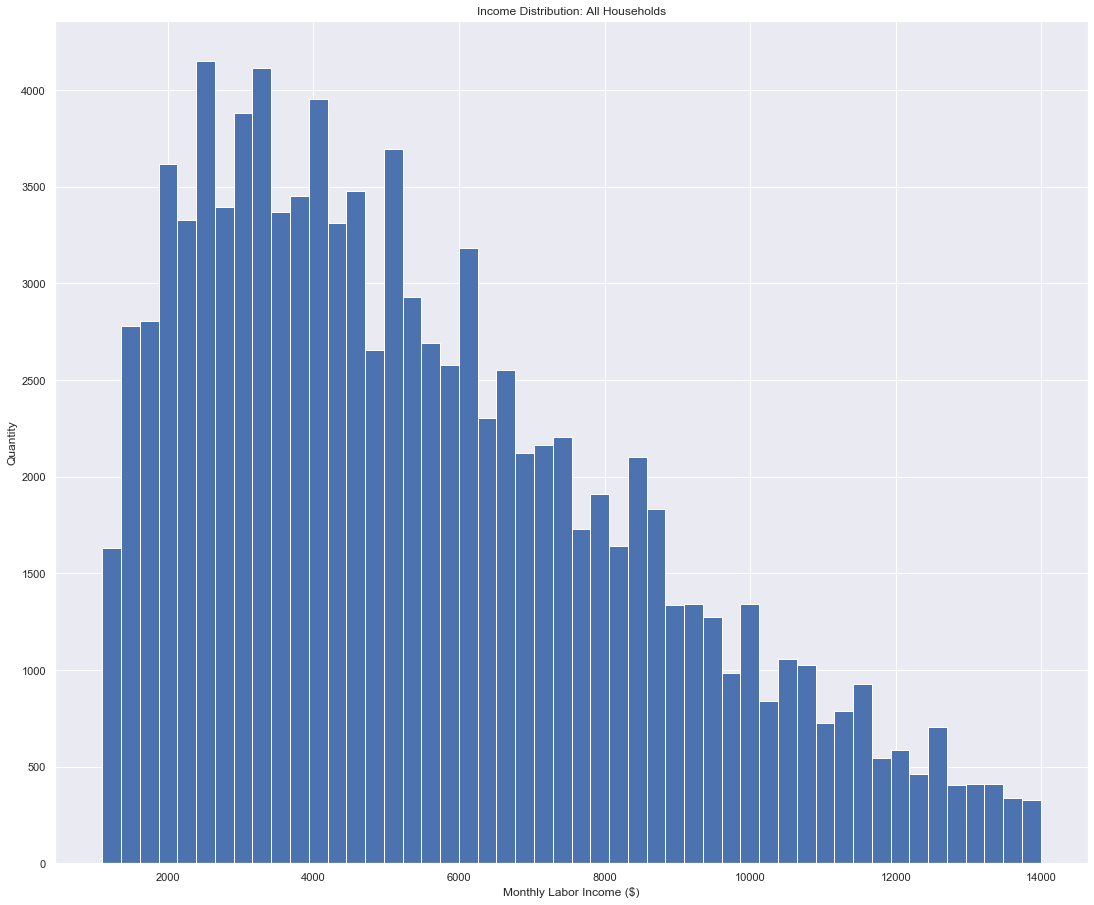

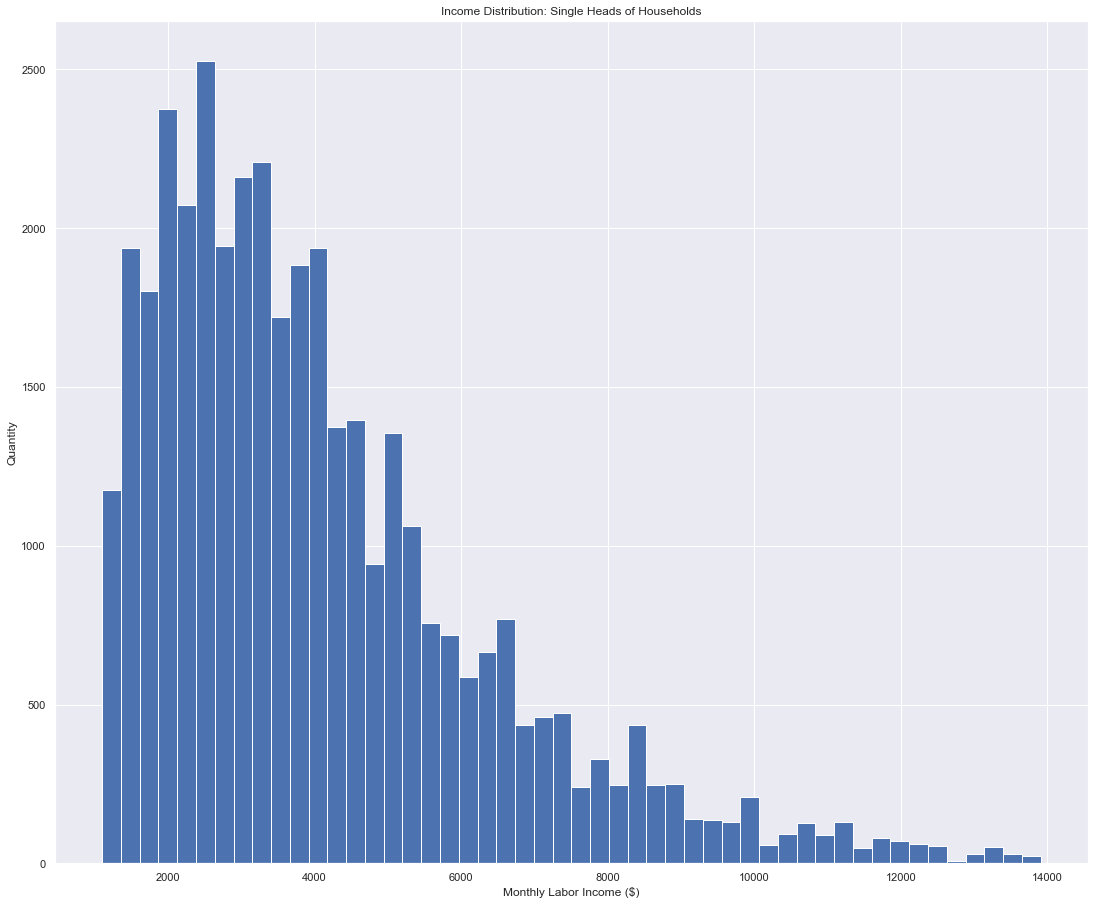

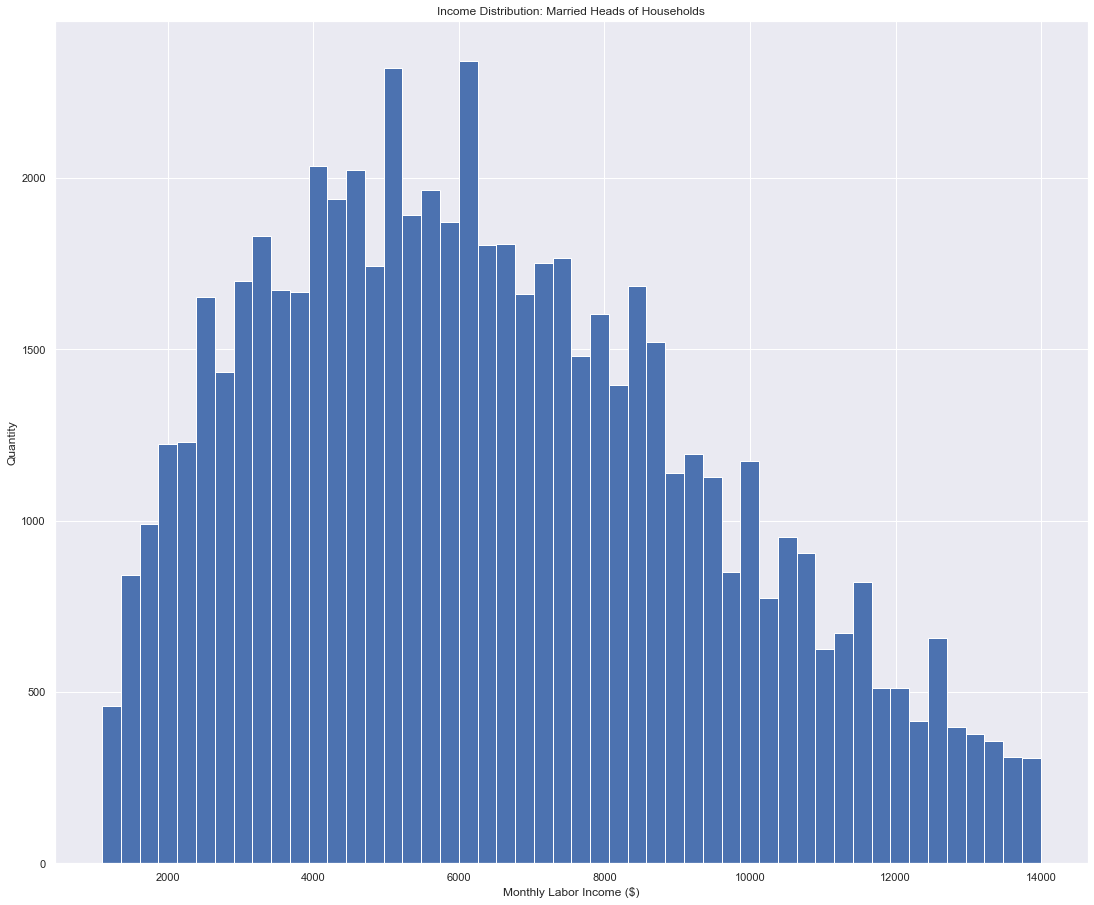

In [50]:
#### Income Distribution

# Histogram Plot for All Households
income = final_data[(final_data[income_var] > 0) & (final_data[income_var] < 14000)][income_var]

quantity, income, bars = plt.hist(income, bins = 50)
plt.title('Income Distribution: All Households')
plt.xlabel('Monthly Labor Income ($)')
plt.ylabel('Quantity')
plt.show()



# Histogram Plot for Single Heads of Households
income_single = final_data[(final_data.spouse == 0) & (final_data[income_var] > 0) & (final_data[income_var] < 14000)][income_var]

quantity, income_single, bars = plt.hist(income_single, bins = 50)
plt.title('Income Distribution: Single Heads of Households')
plt.xlabel('Monthly Labor Income ($)')
plt.ylabel('Quantity')
plt.show()


# Histogram Plot for Married Heads of Households
income_married = final_data[(final_data.spouse == 1) & (final_data[income_var] > 0) & (final_data[income_var] < 14000)][income_var]

quantity, income_married, bars = plt.hist(income_married, bins = 50)
plt.title('Income Distribution: Married Heads of Households')
plt.xlabel('Monthly Labor Income ($)')
plt.ylabel('Quantity')
plt.show()




## Stimulus Payments Distribution

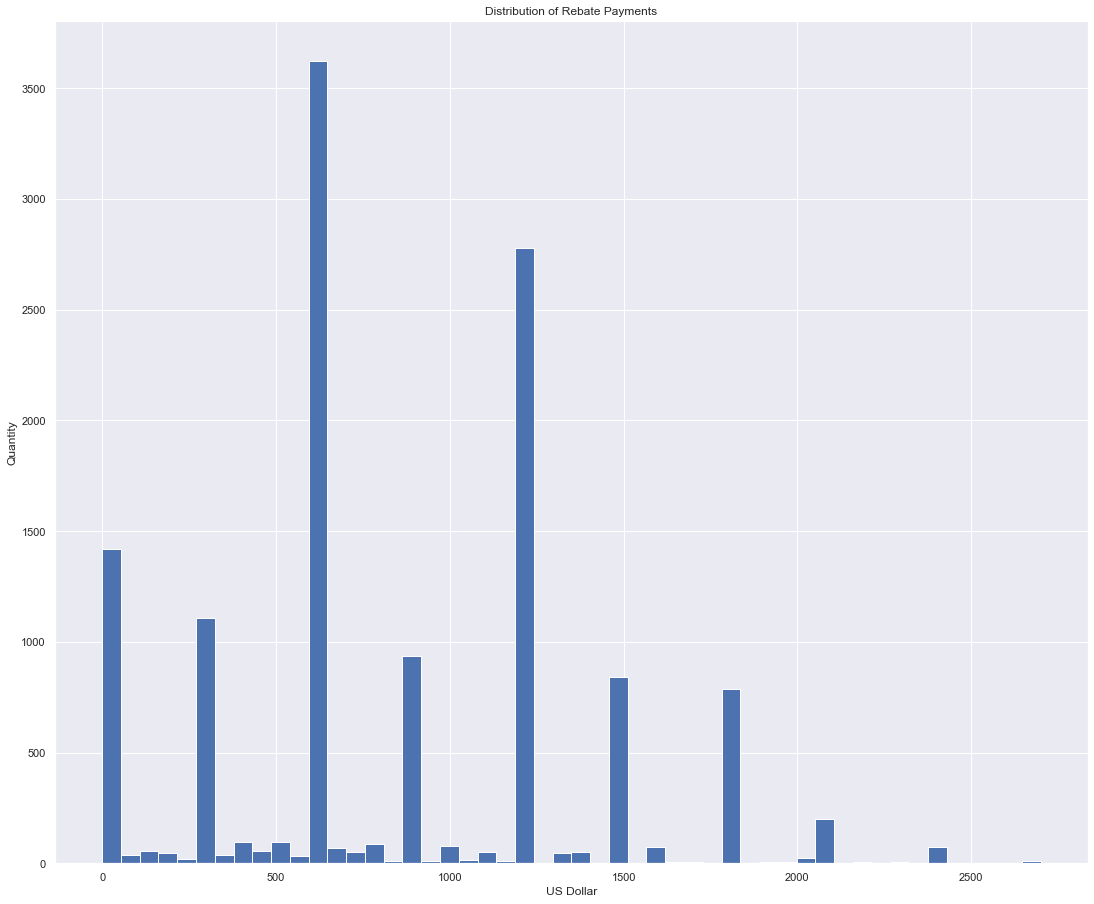

,Quantity,Percentage
reb_size,,
600.0,3604,28.02 %
1200.0,2770,21.53 %
0.0,1376,10.7 %
300.0,1091,8.48 %
900.0,931,7.24 %
1500.0,838,6.51 %
1800.0,786,6.11 %
2100.0,202,1.57 %
500.0,84,0.65 %


In [51]:
#### Stimulus Payment Distribution


# Get the amounts of all rebate payments in the data and take every 8th element of this list to avoid double counting of rebate payments
values = final_data.reb_size[0::8]

quantity, rebate_size, bars = plt.hist(values, bins = 50)
plt.title('Distribution of Rebate Payments')
plt.xlabel('US Dollar')
plt.ylabel('Quantity')
plt.show()


# Statistics to the histogram plot
stats = pd.DataFrame(final_data[0::8].groupby(['reb_size']).size().sort_values(ascending = False))
stats.columns = ['Quantity']
stats['Percentage'] = round(stats.Quantity / sum(stats.Quantity) * 100,2).astype(str) + ' %'
stats.head(10)




## Stimulus Payments for Rich Households

In [52]:
#### Stimulus Payments for Rich Households

# Single households with more than 12,000 USD monthly income
rich_singles = final_data[(final_data.spouse == 0) & (final_data[income_var] >= 12000)]
rich_singles_rebate = rich_singles.reb_receipt.mean()*100
print(round(rich_singles_rebate,2),'percent of single households with monthly earnings of at least 12,000 USD received rebate payments in 2008.')

# Married households with more than 12,000 USD monthly income
rich_married = final_data[(final_data.spouse == 1) & (final_data[income_var] >= 12000)]
rich_married_rebate = rich_married.reb_receipt.mean()*100
print(round(rich_married_rebate,2),'percent of married households with monthly earnings of at least 12,000 USD received rebate payments in 2008.')


30.64 percent of single households with monthly earnings of at least 12,000 USD received rebate payments in 2008.
80.1 percent of married households with monthly earnings of at least 12,000 USD received rebate payments in 2008.


## Stimulus Payments Categorized by Monthly Labor Earnings

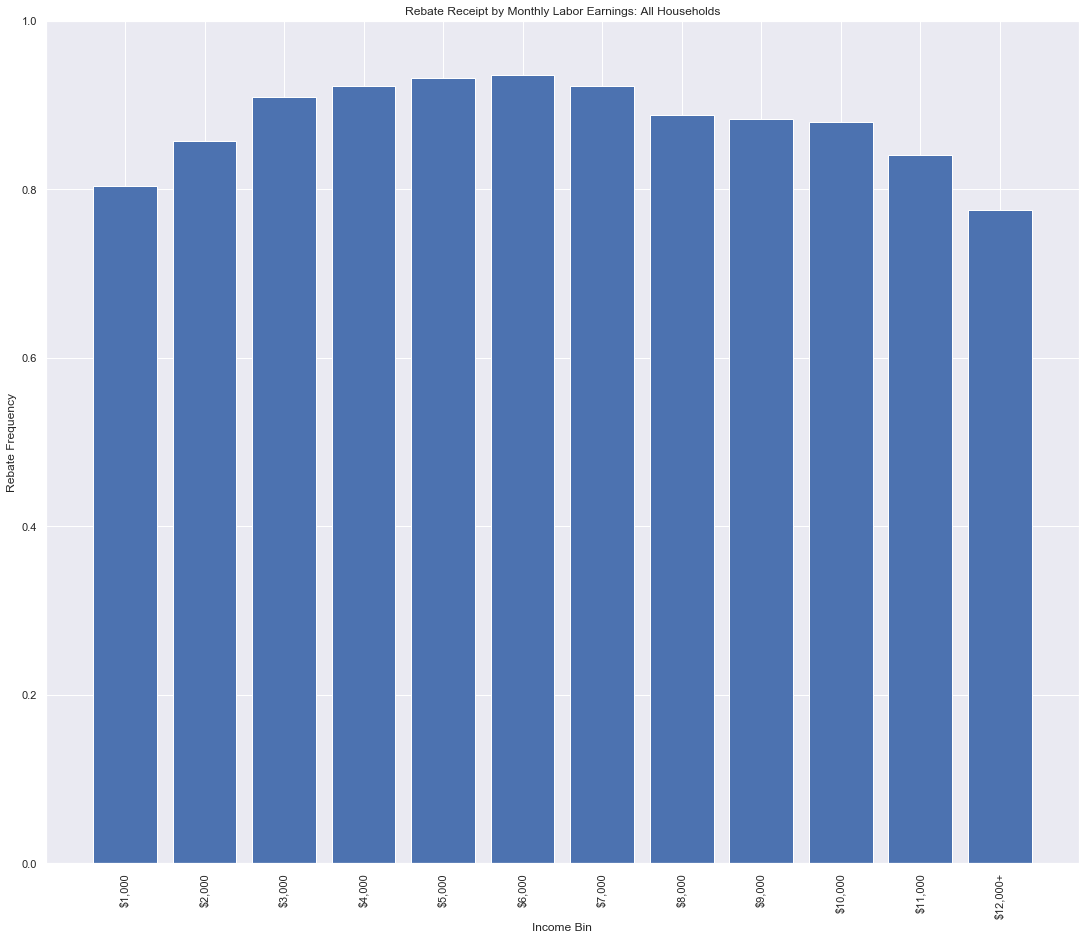

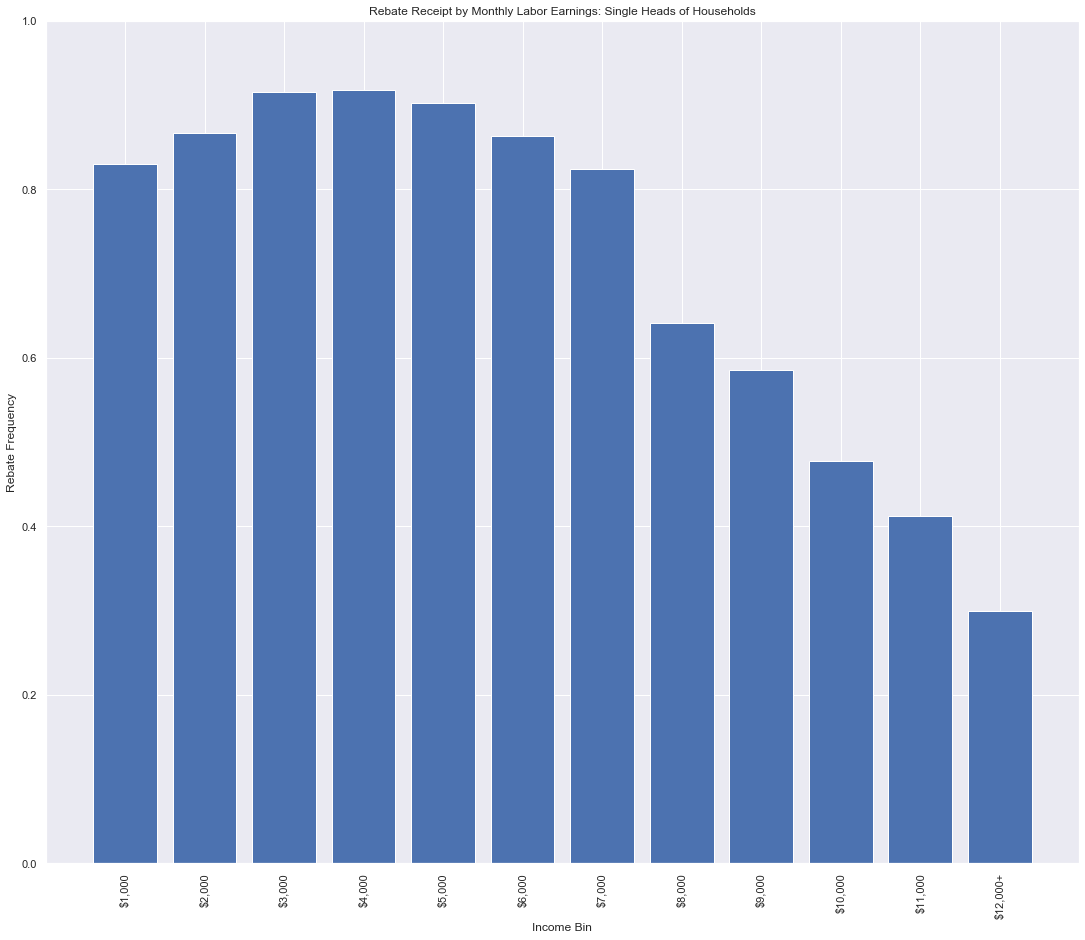

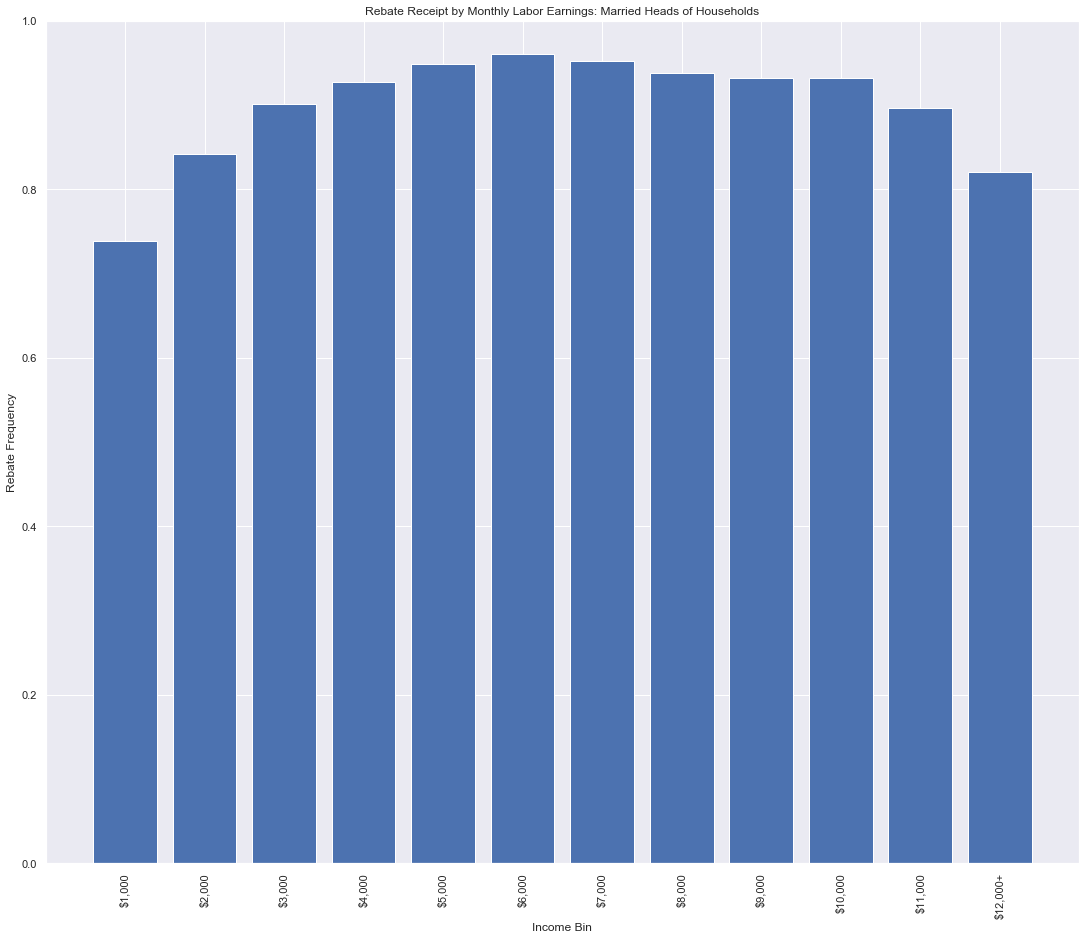

In [53]:
#### Stimulus Payments Categorized by Monthly Labor Earnings



## All Households

bin1 = final_data[(final_data[income_var] <= 1500)].reb_receipt.mean()
bin2 = final_data[(final_data[income_var] > 1500) & (final_data[income_var] <= 2500)].reb_receipt.mean()
bin3 = final_data[(final_data[income_var] > 2500) & (final_data[income_var] <= 3500)].reb_receipt.mean()
bin4 = final_data[(final_data[income_var] > 3500) & (final_data[income_var] <= 4500)].reb_receipt.mean()
bin5 = final_data[(final_data[income_var] > 4500) & (final_data[income_var] <= 5500)].reb_receipt.mean()
bin6 = final_data[(final_data[income_var] > 5500) & (final_data[income_var] <= 6500)].reb_receipt.mean()
bin7 = final_data[(final_data[income_var] > 6500) & (final_data[income_var] <= 7500)].reb_receipt.mean()
bin8 = final_data[(final_data[income_var] > 7500) & (final_data[income_var] <= 8500)].reb_receipt.mean()
bin9 = final_data[(final_data[income_var] > 8500) & (final_data[income_var] <= 9500)].reb_receipt.mean()
bin10 = final_data[(final_data[income_var] > 9500) & (final_data[income_var] <= 10500)].reb_receipt.mean()
bin11 = final_data[(final_data[income_var] > 10500) & (final_data[income_var] <= 11500)].reb_receipt.mean()
bin12 = final_data[(final_data[income_var] > 11500)].reb_receipt.mean()


income_bin = ('$1,000', '$2,000', '$3,000', '$4,000', '$5,000', '$6,000', '$7,000', '$8,000', '$9,000', '$10,000', '$11,000', '$12,000+')
y_pos = np.arange(len(income_bin))
rebate_frequency = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12] # insert y-values here

plt.bar(y_pos, rebate_frequency, align='center', alpha=1)
plt.xticks(y_pos, income_bin, rotation = 90)
plt.ylim(0.0,1.0)
plt.xlabel('Income Bin')
plt.ylabel('Rebate Frequency')
plt.title('Rebate Receipt by Monthly Labor Earnings: All Households')
plt.show()






## Single Heads of Households

bin1 = final_data[(final_data.spouse == 0) & (final_data[income_var] <= 1500)].reb_receipt.mean()
bin2 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 1500) & (final_data[income_var] <= 2500)].reb_receipt.mean()
bin3 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 2500) & (final_data[income_var] <= 3500)].reb_receipt.mean()
bin4 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 3500) & (final_data[income_var] <= 4500)].reb_receipt.mean()
bin5 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 4500) & (final_data[income_var] <= 5500)].reb_receipt.mean()
bin6 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 5500) & (final_data[income_var] <= 6500)].reb_receipt.mean()
bin7 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 6500) & (final_data[income_var] <= 7500)].reb_receipt.mean()
bin8 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 7500) & (final_data[income_var] <= 8500)].reb_receipt.mean()
bin9 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 8500) & (final_data[income_var] <= 9500)].reb_receipt.mean()
bin10 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 9500) & (final_data[income_var] <= 10500)].reb_receipt.mean()
bin11 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 10500) & (final_data[income_var] <= 11500)].reb_receipt.mean()
bin12 = final_data[(final_data.spouse == 0) & (final_data[income_var] > 11500)].reb_receipt.mean()


income_bin = ('$1,000', '$2,000', '$3,000', '$4,000', '$5,000', '$6,000', '$7,000', '$8,000', '$9,000', '$10,000', '$11,000', '$12,000+')
y_pos = np.arange(len(income_bin))
rebate_frequency = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12] # insert y-values here

plt.bar(y_pos, rebate_frequency, align='center', alpha=1)
plt.xticks(y_pos, income_bin, rotation = 90)
plt.ylim(0.0,1.0)
plt.xlabel('Income Bin')
plt.ylabel('Rebate Frequency')
plt.title('Rebate Receipt by Monthly Labor Earnings: Single Heads of Households')
plt.show()


## Married Heads of Households


bin1 = final_data[(final_data.spouse == 1) & (final_data[income_var] <= 1500)].reb_receipt.mean()
bin2 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 1500) & (final_data[income_var] <= 2500)].reb_receipt.mean()
bin3 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 2500) & (final_data[income_var] <= 3500)].reb_receipt.mean()
bin4 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 3500) & (final_data[income_var] <= 4500)].reb_receipt.mean()
bin5 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 4500) & (final_data[income_var] <= 5500)].reb_receipt.mean()
bin6 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 5500) & (final_data[income_var] <= 6500)].reb_receipt.mean()
bin7 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 6500) & (final_data[income_var] <= 7500)].reb_receipt.mean()
bin8 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 7500) & (final_data[income_var] <= 8500)].reb_receipt.mean()
bin9 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 8500) & (final_data[income_var] <= 9500)].reb_receipt.mean()
bin10 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 9500) & (final_data[income_var] <= 10500)].reb_receipt.mean()
bin11 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 10500) & (final_data[income_var] <= 11500)].reb_receipt.mean()
bin12 = final_data[(final_data.spouse == 1) & (final_data[income_var] > 11500)].reb_receipt.mean()


income_bin = ('$1,000', '$2,000', '$3,000', '$4,000', '$5,000', '$6,000', '$7,000', '$8,000', '$9,000', '$10,000', '$11,000', '$12,000+')
y_pos = np.arange(len(income_bin))
rebate_frequency = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12] # insert y-values here

plt.bar(y_pos, rebate_frequency, align='center', alpha=1)
plt.xticks(y_pos, income_bin, rotation = 90)
plt.ylim(0.0,1.0)
plt.xlabel('Income Bin')
plt.ylabel('Rebate Frequency')
plt.title('Rebate Receipt by Monthly Labor Earnings: Married Heads of Households')
plt.show()


## Stimulus Payments Categorized by Month

,Quantity,Percentage
Rebate Month,,
June,3733,29.02 %
May,3574,27.79 %
July,2554,19.86 %
No rebate,1376,10.7 %
April,823,6.4 %
August,515,4.0 %
September,135,1.05 %
October,76,0.59 %
November,56,0.44 %


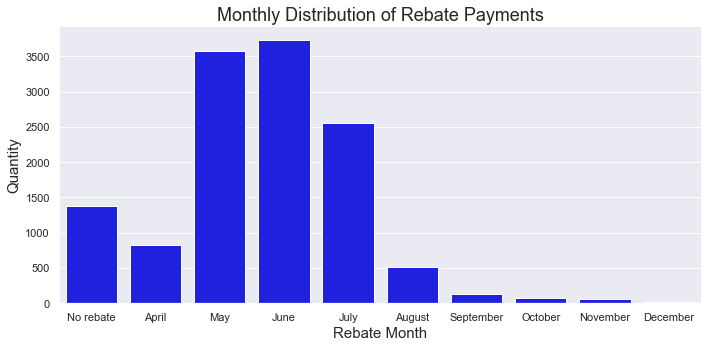

In [54]:
# Histogram
months = ['No rebate', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.catplot(x='reb_month',  kind='count', color = 'blue', data=final_data[0::8], height=5, aspect=2, order = months)
plt.xlabel('Rebate Month', size=15)
plt.ylabel('Quantity', size=15)
plt.title('Monthly Distribution of Rebate Payments', size=18)
plt.tight_layout()


# Statistics to the histogram plot
stats = pd.DataFrame(final_data[0::8].groupby(['reb_month']).size().sort_values(ascending = False))
stats.columns = ['Quantity']
stats['Percentage'] = round(stats.Quantity / sum(stats.Quantity) * 100,2).astype(str) + ' %'
stats.index.names = ['Rebate Month']
stats

## Rebate Receiving Calculations

In [55]:
## Number of households in the sample
num_households = len(final_data.ssuid.unique())

## Number of households in the sample receiving a rebate
num_rebate_receiving = len((final_data.groupby(['ssuid']).mean().reb_receipt == 1)[(final_data.groupby(['ssuid']).mean().reb_receipt == 1) == True].index)

## Number of households in the sample receiving a rebate before the observation period
no_rebate = final_data[final_data.reb_receipt == 0]
households_no_rebate = no_rebate.ssuid.unique()
final_data_rebate_only = final_data[~final_data['ssuid'].isin(households_no_rebate)]
num_rebate_before = len((final_data_rebate_only.groupby(['ssuid']).mean().rebate_payment == 0)[(final_data_rebate_only.groupby(['ssuid']).mean().rebate_payment == 0) == True].index)

## Number of households in the sample receiving a rebate in the observation period
num_rebate_within = len((final_data.groupby(['ssuid']).mean().rebate_payment == 0.125)[(final_data.groupby(['ssuid']).mean().rebate_payment == 0.125) == True].index)

## Number of households in the treatment group
num_treatment = num_rebate_within

## Number of households in the control group
num_control = len((final_data.groupby(['ssuid']).mean().rebate_payment == 0)[(final_data.groupby(['ssuid']).mean().rebate_payment == 0) == True].index)



# Arrange the statistics in a table like format
data_statistics = pd.DataFrame([[num_households, num_households*8],
                           [num_rebate_receiving, num_rebate_receiving],
                           [num_rebate_before, num_rebate_before],
                           [num_rebate_within, num_rebate_within],     
                           [num_treatment, num_treatment],
                           [num_control, num_households*8 - num_treatment]],
                        columns = list(['Number of Households', 'Number of Observations']), 
                        index = ['In the sample', 'Receiving a rebate', 
                                 'Receiving rebate before first observation', 
                                 'Receiving rebate within the observation period', 
                                 'In the treatment group',
                                 'In the control group'])
data_statistics

,Number of Households,Number of Observations
In the sample,12863,102904
Receiving a rebate,11487,11487
Receiving rebate before first observation,5913,5913
Receiving rebate within the observation period,5574,5574
In the treatment group,5574,5574
In the control group,7289,97330


# Uplifting

**Idea:**

**First Step**

I build two random forests, one that is trained with the treatment group data, and one that is using the control group data only.

I split the treatment and control group into a training sample and a test sample in order to fit and test both algorithms. 

**Second Step**

I use both algorithms for predicting labor income values. For every household, I will get a prediction from the treatment random forest and one from the control random forest. Taking the difference results in the labor income change for each household in a given observation month. 

Important: For my predictions in Step 2, I do **NOT** use all observations in the original data set. In fact, I only predict values for months where a rebate payment happened and months after. 

Below, you will see sections 6.1 and 6.2. In 6.1, I will conduct the First Step, whereas in 6.2 I will select the observations whose predictions I am really interested in. 

## Select the data for fitting the algorithm

In [56]:
## Exclude features that are not used for the analysis   
    
data = final_data.drop(['ssuid', 'type', 'totwork', 'ehrefper', 'epppnum', income_var_mean, 'totcens', 'whfnwgt', 
                        'reb4', 'amt4', 'reb5', 'amt5', 'reb6', 'amt6', 'reb7', 'amt7', 'reb8', 'amt8', 
                        'reb9', 'amt9', 'reb10', 'amt10', 'reb11', 'amt11', 'reb12', 'amt12', 'totearn', 
                        'tpearn', 'tftotinc', 'tptotinc', 'totinc', 'srefmon', 'reb_month', 'month', 'sex_if_single', 
                        'earn_male', 'earn_female', 'rf_new'], axis = 1)



#### Uplifting

# Split the dataset into two sets for treatment and control group
treatment = data[data.rebate_payment == 1]
control = data[data.rebate_payment == 0]

# TFEARN as the target variable, which I call label
treatment_labels = treatment[income_var]
control_labels = control[income_var]

# Remove the labels from the features
treatment_features = treatment.drop(['labor_income_ratio', income_var], axis = 1)
control_features = control.drop(['rebate_uplifting', 'rebate_uplifting_spend', 'rebate_uplifting_save', 
                                               'rebate_uplifting_debt','labor_income_ratio', income_var], axis = 1)

# Saving feature names for later use
treatment_features_list = list(treatment_features.columns)
control_features_list = list(control_features.columns)

## Select rebate months and lags for predictions

In [57]:
## Select months after rebate payments only for the predictions
rebates_receiving_households = final_data[final_data.reb_receipt == 1]
result_months = rebates_receiving_households[(rebates_receiving_households.month_numerical >= rebates_receiving_households.reb_month_numerical) | (rebates_receiving_households.year == 2009)]

result_months_drop = result_months.drop(['ssuid', 'type', 'totwork', 'ehrefper', 'epppnum', income_var_mean, 'totcens', 'whfnwgt', 
                        'reb4', 'amt4', 'reb5', 'amt5', 'reb6', 'amt6', 'reb7', 'amt7', 'reb8', 'amt8', 
                        'reb9', 'amt9', 'reb10', 'amt10', 'reb11', 'amt11', 'reb12', 'amt12', 'totearn', 
                        'tpearn', 'tftotinc', 'tptotinc', 'totinc', 'srefmon', 'reb_month', 'month', 'sex_if_single', 
                        'earn_male', 'earn_female', 'rf_new'], axis = 1)

features = result_months_drop.drop(['labor_income_ratio', income_var], axis = 1)
features_list = list(features.columns)

# Define labels
labels = result_months[income_var]

# Define rebates
rebates = result_months.reb_size

# Split the data

In [58]:
#### Split the data

# Split the data into training and testing sets
treatment_train_features, treatment_test_features, treatment_train_labels, treatment_test_labels = train_test_split(treatment_features, treatment_labels, test_size = 0.2, random_state = 0)
control_train_features, control_test_features, control_train_labels, control_test_labels = train_test_split(control_features, control_labels, test_size = 0.2, random_state = 0)

# Random Forest

## Drop the dummy variables and define the feature arrays

In [59]:
## Select variables to be dropped

to_drop = ['reb_spend', 'reb_save', 'reb_debt', 'reb_size', 'reb_receipt', 
           'year_2008', 'year_2009', 'Dummy_January', 'Dummy_February', 
           'Dummy_March', 'Dummy_May', 'Dummy_June', 'Dummy_July', 'Dummy_August', 
           'Dummy_September', 'Dummy_October', 'Dummy_November', 'Dummy_December', 
           'First Reference month', 'Second Reference month', 'Third Reference month', 
           'Fourth Reference month', 'Wave_1', 'Wave_2'] # drop all the dummy variables that I don't need for the RF



rf_treatment_train_features = treatment_train_features.drop(to_drop, axis = 1)
rf_treatment_test_features = treatment_test_features.drop(to_drop, axis = 1)

rf_control_train_features = control_train_features.drop(to_drop, axis = 1)
rf_control_test_features = control_test_features.drop(to_drop, axis = 1)

rf_treatment_features = features.drop(to_drop, axis = 1)
rf_control_features = rf_treatment_features.drop(['rebate_uplifting', 'rebate_uplifting_spend', 
                                                    'rebate_uplifting_save', 'rebate_uplifting_debt'], axis = 1)


# Saving the random forest feature names for later use
rf_treatment_features_list = rf_features_list = list(rf_treatment_features.columns)
rf_control_features_list = list(rf_control_features.columns)

## Train the random forest algorithm and make predictions

In [60]:
#### Setting up the RF #########################################

rf_treatment = RandomForestRegressor(n_estimators = n_est, random_state = r_s, max_depth = m_d, 
                                            max_features = feat, oob_score = oob_score, bootstrap = bootstrap)
rf_control = RandomForestRegressor(n_estimators = n_est, random_state = r_s, max_depth = m_d, 
                                            max_features = feat, oob_score = oob_score, bootstrap = bootstrap)


#### Train the RF #########################################

# Train the model on training data
rf_treatment.fit(rf_treatment_train_features, treatment_train_labels);
rf_control.fit(rf_control_train_features, control_train_labels);

# Report scores for both random forest models
rf_treatment_training_score = rf_treatment.score(rf_treatment_train_features, treatment_train_labels);
rf_control_training_score = rf_control.score(rf_control_train_features, control_train_labels);

rf_treatment_oob_score = rf_treatment.oob_score_
rf_control_oob_score = rf_control.oob_score_

rf_treatment_test_score = rf_treatment.score(rf_treatment_test_features, treatment_test_labels);
rf_control_test_score = rf_control.score(rf_control_test_features, control_test_labels);



#### Predict with the RF ####################################


#### Make Predictions on the Training Set

# Use the forest's predict method on the training data
rf_treatment_train_predictions = rf_treatment.predict(rf_treatment_train_features)
rf_control_train_predictions = rf_control.predict(rf_control_train_features)

# Calculate the absolute errors
rf_treatment_train_errors = abs(rf_treatment_train_predictions - treatment_train_labels)
rf_control_train_errors = abs(rf_control_train_predictions - control_train_labels)


#### Make Predictions on the Test Set

# Use the forest's predict method on the test data
rf_treatment_test_predictions = rf_treatment.predict(rf_treatment_test_features)
rf_control_test_predictions = rf_control.predict(rf_control_test_features)

# Calculate the absolute errors
rf_treatment_test_errors = abs(rf_treatment_test_predictions - treatment_test_labels)
rf_control_test_errors = abs(rf_control_test_predictions - control_test_labels)


#### Make predictions for whole data

# Predict labor income
rf_treatment_predictions = rf_treatment.predict(rf_treatment_features)
rf_control_predictions = rf_control.predict(rf_control_features)

# Calculate the absolute errors
rf_treatment_errors = abs(rf_treatment_predictions - labels)
rf_control_errors = abs(rf_control_predictions - labels)


####
rf_treatment_score = rf_treatment.score(rf_treatment_features, labels);
rf_control_score = rf_control.score(rf_control_features, labels);




#### Compute the differences between the treatment and control group
rf_diff = rf_treatment_predictions - rf_control_predictions
rf_mean_diff = np.mean(rf_diff)
rf_median_diff = np.median(rf_diff)

#################################################################################################################

#### Create a new row with the percentual labor income change for every observation
rf_perc_diff = np.divide(rf_diff, labels) #* 100 # to transform it into percentage points
rf_perc_diff[np.isinf(rf_perc_diff)] = 0
rf_mean_perc_diff = np.mean(rf_perc_diff)
rf_median_perc_diff = np.median(rf_perc_diff)



#################################################################################################################

#### Create a new row with the marginal labor income change for every rebate dollars
rf_marg_diff = np.divide(rf_diff, rebates) #* 100 # to transform it into percentage points
rf_marg_diff[np.isinf(rf_marg_diff)] = 0
rf_mean_marg_diff = np.mean(rf_marg_diff)
rf_median_marg_diff = np.median(rf_marg_diff)



#################################################################################################################


#### Attach the results to the final_data Dataframe - this is needed for further analysis! 

result_months['rf_treatment_predictions'] = rf_treatment_predictions
result_months['rf_control_predictions'] = rf_control_predictions
result_months['rf_labor_income_diff'] = rf_diff
result_months['rf_perc_labor_income_diff'] = rf_perc_diff
result_months['rf_marg_labor_income_diff'] = rf_marg_diff



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

## Results

In [61]:
#### Create Data Tables for the results of the estimation 

lag = 'All'
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results.columns.names = [str(lag) + ' Months']
else: 
    rf_results.columns.names = ['Lags ' + str(lag)]


#################################################################################################################

## Results for rebate months only

dataframe_data = result_months[final_data.rebate_payment == 1]

rf_results_rebate_month = pd.DataFrame([[round(np.mean(dataframe_data.rf_labor_income_diff),3), round(np.std(dataframe_data.rf_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_labor_income_diff),3), round(np.percentile(dataframe_data.rf_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_labor_income_diff),3), round(np.percentile(dataframe_data.rf_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_labor_income_diff), 3)],
                                        [round(np.mean(dataframe_data.rf_perc_labor_income_diff),3), round(np.std(dataframe_data.rf_perc_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_perc_labor_income_diff),3), round(np.percentile(dataframe_data.rf_perc_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_perc_labor_income_diff),3), round(np.percentile(dataframe_data.rf_perc_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_perc_labor_income_diff), 3)],
                                        [round(np.mean(dataframe_data.rf_marg_labor_income_diff),3), round(np.std(dataframe_data.rf_marg_labor_income_diff), 3), 
                                         round(min(dataframe_data.rf_marg_labor_income_diff),3), round(np.percentile(dataframe_data.rf_marg_labor_income_diff,25),3), 
                                         round(np.median(dataframe_data.rf_marg_labor_income_diff),3), round(np.percentile(dataframe_data.rf_marg_labor_income_diff,75),3), 
                                         round(max(dataframe_data.rf_marg_labor_income_diff), 3)]],
                                    columns = list(['Mean Difference', 'Standard Deviation', 
                                                    'Min', '25th Percentile', 
                                                    'Median Difference', '75th Percentile', 
                                                    'Max']),  
                                    index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])

rf_results_rebate_month.columns.names = ['Rebate Months Only']

#################################################################################################################




lag = [1]
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results_lag1 = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results_lag1.columns.names = [str(lag) + ' Months']
else: 
    rf_results_lag1.columns.names = ['Lags ' + str(lag)]


#################################################################################################################






#################################################################################################################



lag = [2]
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results_lag2 = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results_lag2.columns.names = [str(lag) + ' Months']
else: 
    rf_results_lag2.columns.names = ['Lags ' + str(lag)]


    

    
    
#################################################################################################################



lag = [1,2]
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results_lag12 = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results_lag12.columns.names = [str(lag) + ' Months']
else: 
    rf_results_lag12.columns.names = ['Lags ' + str(lag)]
    
    
    
#################################################################################################################







#################################################################################################################



lag = [3]
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results_lag3 = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results_lag3.columns.names = [str(lag) + ' Months']
else: 
    rf_results_lag3.columns.names = ['Lags ' + str(lag)]


#################################################################################################################






#################################################################################################################



lag = [4]
selected_lags = lag_function(lag,frame=result_months)



#################################################################################################################

# Arrange the statistics in a table like format
rf_results_lag4 = pd.DataFrame([[round(np.mean(selected_lags['rf_labor_income_diff']),3), round(np.std(selected_lags['rf_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],25),3), 
                            round(np.median(selected_lags['rf_labor_income_diff']),3), round(np.percentile(selected_lags['rf_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_perc_labor_income_diff']),3), round(np.std(selected_lags['rf_perc_labor_income_diff']), 3), 
                            round(min(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_perc_labor_income_diff']),3), round(np.percentile(selected_lags['rf_perc_labor_income_diff'],75),3),
                            round(max(selected_lags['rf_perc_labor_income_diff']), 3)],
                           [round(np.mean(selected_lags['rf_marg_labor_income_diff']),3), round(np.std(selected_lags['rf_marg_labor_income_diff']), 3),
                            round(min(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],25),3),
                            round(np.median(selected_lags['rf_marg_labor_income_diff']),3), round(np.percentile(selected_lags['rf_marg_labor_income_diff'],75),3), 
                            round(max(selected_lags['rf_marg_labor_income_diff']), 3)]],
                        columns = list(['Mean Difference', 'Standard Deviation', 
                                        'Min', '25th Percentile', 
                                        'Median Difference', '75th Percentile', 
                                        'Max']), 
                        index = ['Labor Income Difference', 'Difference relative to Actual Labor Income', 
                                        'Difference relative to Rebate Amount'])


if lag == 'All': 
    rf_results_lag4.columns.names = [str(lag) + ' Months']
else: 
    rf_results_lag4.columns.names = ['Lags ' + str(lag)]


#################################################################################################################






display_below_each_other(rf_results, rf_results_rebate_month, rf_results_lag1,rf_results_lag2, rf_results_lag12, rf_results_lag3, rf_results_lag4)



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


All Months,Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,115.064,450.372,-1185.158,-226.937,-0.164,414.271,1856.987
Difference relative to Actual Labor Income,0.055,0.159,-0.698,-0.034,-0.000,0.102,1.533
Difference relative to Rebate Amount,0.516,12.555,-318.696,-0.205,-0.000,0.668,1074.513
Rebate Months Only,Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,-64.961,422.648,-1185.158,-327.733,-89.553,190.065,1486.616
Difference relative to Actual Labor Income,-0.027,0.110,-0.698,-0.075,-0.017,0.034,0.533
Difference relative to Rebate Amount,-0.181,9.857,-280.158,-0.473,-0.091,0.189,588.582
Lags [1],Mean Difference,Standard Deviation,Min,25th Percentile,Median Difference,75th Percentile,Max
Labor Income Difference,8.614,329.256,-757.778,-252.663,-40.649,255.138,1420.642
Difference relative to Actual Labor Income,0.023,0.101,-0.370,-0.040,-0.007,0.072,0.797


**Correlation of Measurement Models (1),(2) and (3)**

In [62]:
## I measure the correlation of the three measurement models and show the results as a table below.

## Pearson Coefficients
corr_1_2,p_1_2 = pearsonr(result_months['rf_labor_income_diff'], result_months['rf_perc_labor_income_diff'])
corr_1_3,p_1_3 = pearsonr(result_months['rf_labor_income_diff'], result_months['rf_marg_labor_income_diff'])
corr_2_3,p_2_3 = pearsonr(result_months['rf_perc_labor_income_diff'], result_months['rf_marg_labor_income_diff'])

## Spearman Coefficients
s_corr_1_2,s_p_1_2 = spearmanr(result_months['rf_labor_income_diff'], result_months['rf_perc_labor_income_diff'])
s_corr_1_3,s_p_1_3 = spearmanr(result_months['rf_labor_income_diff'], result_months['rf_marg_labor_income_diff'])
s_corr_2_3,s_p_2_3 = spearmanr(result_months['rf_perc_labor_income_diff'], result_months['rf_marg_labor_income_diff'])


model_correlation = pd.DataFrame([[round(corr_1_2,3),round(p_1_2,3),round(s_corr_1_2,3),round(s_p_1_2,3)],
                           [round(corr_1_3,3),round(p_1_3,3),round(s_corr_1_3,3),round(s_p_1_3,3)],
                           [round(corr_2_3,3),round(p_2_3,3),round(s_corr_2_3,3),round(s_p_2_3,3)]],
                        columns = list(['Pearson Correlation', 'Pearson p-value', 
                                        'Spearman Correlation', 'Spearman p-value']), 
                        index = ['(1)-(2)', '(1)-(3)', 
                                        '(2)-(3)'])
model_correlation


,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
(1)-(2),0.868,0.0,0.955,0.0
(1)-(3),0.095,0.0,0.963,0.0
(2)-(3),0.086,0.0,0.937,0.0


## Accuracy

**First, I report the estimated R^2 scores**

In [63]:
# Arrange the score statistics in a table like format
rf_score = pd.DataFrame([[round(rf_treatment_training_score,4), round(rf_treatment_oob_score,4), round(rf_treatment_test_score,4), round(rf_treatment_score,4)],
                         [round(rf_control_training_score,4), round(rf_control_oob_score,4), round(rf_control_test_score,4), round(rf_control_score,4)]], 
                     columns = list(['R^2 Training Score', 'Out of Bag Score', 'R^2 Test Score', 'R^2 Entire Dataset Score']))

rf_score.rename(index = {0: 'Treatment', 1: 'Control'})


,R^2 Training Score,Out of Bag Score,R^2 Test Score,R^2 Entire Dataset Score
Treatment,0.2678,0.2409,0.2594,0.1929
Control,0.2353,0.2339,0.2242,0.2397


**Following the approach by Gulyas and Pytka, I construct 25 response bins and compare RF estimates with OLS estimates for each bin**


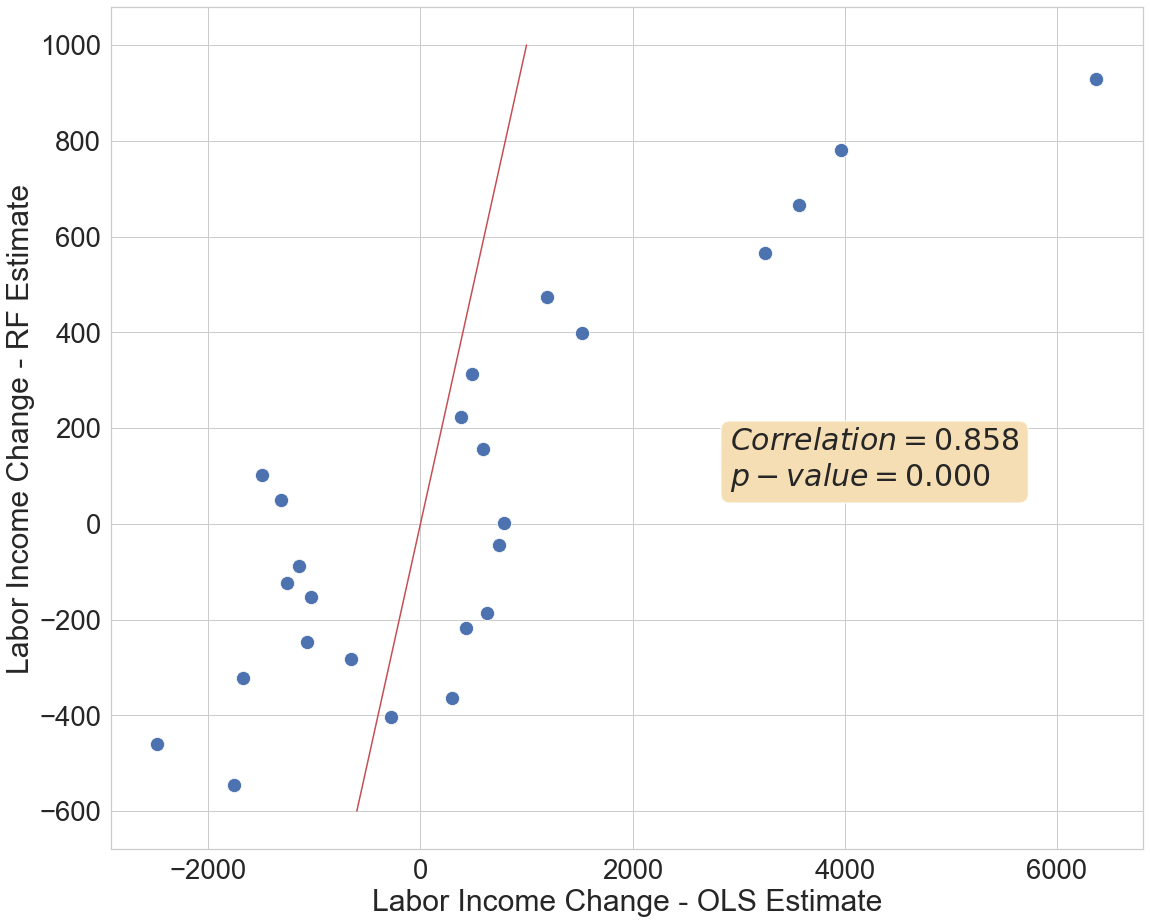

In [64]:
#### 1. Bin all households by their estimated labor income change into 25 bins and plot OLS estimates vs. RF estimates for each bin
data_accuracy = result_months.copy().drop('Is In Selected Lags', axis = 1)


data_accuracy = data_accuracy.sort_values(by = ['rf_labor_income_diff'])

rf_bins_estimates = []
ols_bins_estimates = []

# Create 25 bins
number_bins = 25
cut_points = np.arange(1,len(data_accuracy),len(data_accuracy)/number_bins)

for i, val in enumerate(cut_points):
    
    if i == 0:      
        
        df = data_accuracy.iloc[ 0:int(cut_points[1]) , : ]
    
    else: 
        df = data_accuracy.iloc[ int((val)-(val/(i+1))):int(val), : ]
    
    # RF estimates
    rf_bins_estimates.append(np.mean(df.rf_labor_income_diff))
        
    #OLS estimates
    ols_features = df[['rebate_payment', 'tage', 'famsize', 'spouse', 'flex', 'moonlit', 'selfemp', 
                                  'year_2008', 'year_2009', 'Dummy_January', 'Dummy_February', 'Dummy_March', 
                                  'Dummy_May', 'Dummy_June', 'Dummy_July', 'Dummy_August', 'Dummy_September', 
                                  'Dummy_October', 'Dummy_November', 'Dummy_December', 'First Reference month', 
                                  'Second Reference month', 'Third Reference month', 'Fourth Reference month', 
                                  'reb_month_numerical', 'Wave_1', 'Wave_2', 'rebate_uplifting_spend', 'rebate_uplifting_save', 
                                  'rebate_uplifting_debt']]
    ols_label = df['tfearn']
    ols_model = LinearRegression()
    ols_results = ols_model.fit(ols_features, ols_label)
    ols_bins_estimates.append(ols_results.coef_[0])


sns.set(rc = {'figure.figsize': (18.5,15.5)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')


pearson_coef, p = pearsonr(ols_bins_estimates, rf_bins_estimates)


fig, ax = plt.subplots()

text = '\n'.join((
    r'$Correlation=%.3f$' % (pearson_coef, ),
    r'$p-value=%.3f$' % (p, )))

sns.scatterplot(ols_bins_estimates,rf_bins_estimates, s = 200, ax = ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

ax.text(0.6, 0.5, text, transform=ax.transAxes, fontsize=30,
        verticalalignment='top', bbox=props)


ax.set(xlabel = 'Labor Income Change - OLS Estimate', ylabel = 'Labor Income Change - RF Estimate')

x = np.linspace(-600, 1000, 10)
sns.lineplot(x,x, ax=ax, color = 'r')

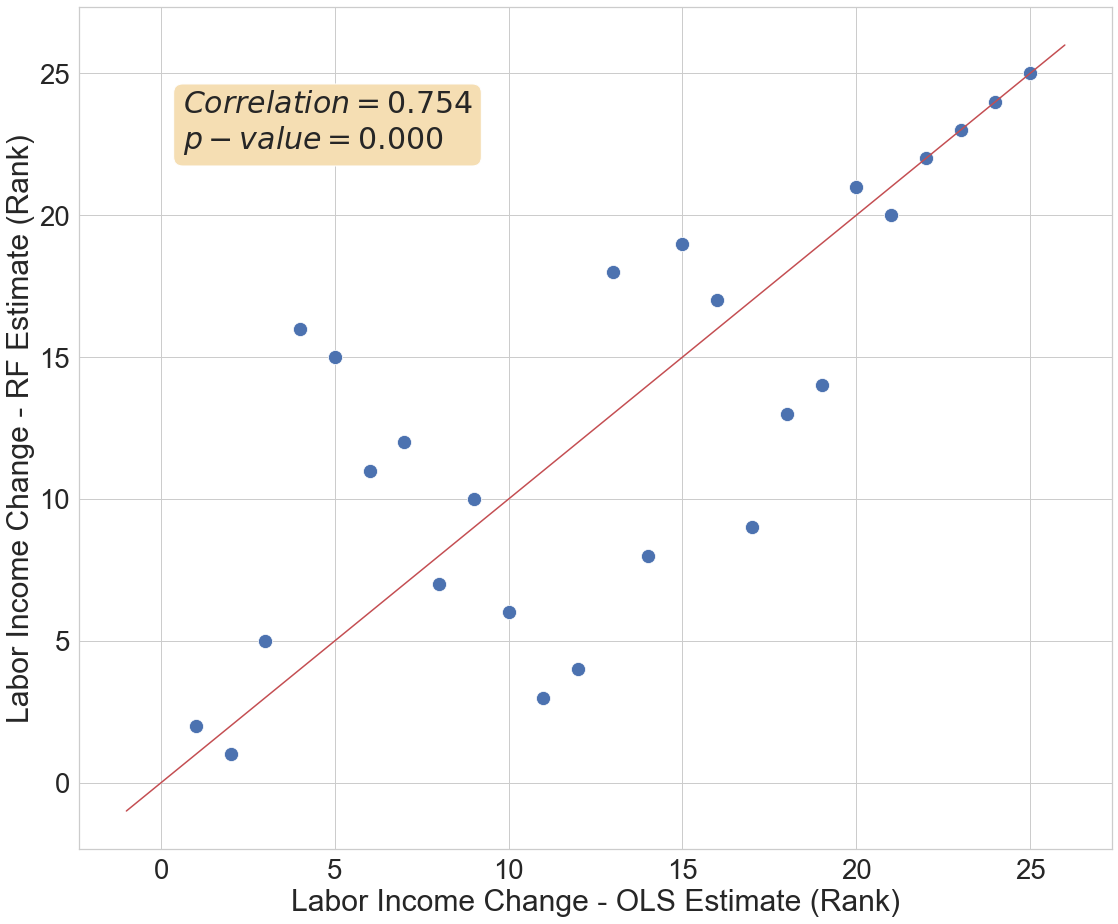

In [65]:
#### 2. Compute the ranks for both estimations and compare RF ranks with OLS ranks

dtf_sorted = pd.DataFrame({'OLS Bins Estimate': np.sort(ols_bins_estimates), 
                    'OLS Rank': np.arange(1,number_bins+1,1)})

df_rank_preliminary = pd.DataFrame({'RF Bins Estimate': rf_bins_estimates, 
                        'OLS Bins Estimate': ols_bins_estimates, 
                        'RF Rank': np.arange(1,number_bins+1,1)})

df_rank = df_rank_preliminary.merge(dtf_sorted, on='OLS Bins Estimate')

rf_ranks = df_rank['RF Rank']
ols_ranks = df_rank['OLS Rank']

sns.set(rc = {'figure.figsize': (18.5,15.5)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')

spearman_coef, p = spearmanr(ols_bins_estimates, rf_bins_estimates)
fig, ax = plt.subplots()

text = '\n'.join((
    r'$Correlation=%.3f$' % (spearman_coef, ),
    r'$p-value=%.3f$' % (p, )))




sns.scatterplot(ols_ranks,rf_ranks, s = 200, ax = ax)

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

ax.text(0.1, 0.9, text, transform=ax.transAxes, fontsize=30,
        verticalalignment='top', bbox=props)


ax.set(xlabel = 'Labor Income Change - OLS Estimate (Rank)', ylabel = 'Labor Income Change - RF Estimate (Rank)')

x = np.linspace(-1, number_bins+1, 5)
sns.lineplot(x,x, ax=ax, color = 'r')

# Analysis

**Number of observations in months considered**

In [66]:
## All Observation Months
number_obs_all = len(result_months)
number_households_all = len(result_months.ssuid.unique())

## Rebate Months
number_obs_0 = len(lag_function([0],frame=result_months))
number_households_0 = len(lag_function([0],frame=result_months).ssuid.unique())

## Lag 1
number_obs_1 = len(lag_function([1],frame=result_months))
number_households_1 = len(lag_function([1],frame=result_months).ssuid.unique())

## Lag 2
number_obs_2 = len(lag_function([2],frame=result_months))
number_households_2 = len(lag_function([2],frame=result_months).ssuid.unique())

## Lags 1 and 2
number_obs_12 = len(lag_function([1,2],frame=result_months))
number_households_12 = len(lag_function([1,2],frame=result_months).ssuid.unique())

## Lag 3
number_obs_3 = len(lag_function([3],frame=result_months))
number_households_3 = len(lag_function([3],frame=result_months).ssuid.unique())

## Lag 4
number_obs_4 = len(lag_function([4],frame=result_months))
number_households_4 = len(lag_function([4],frame=result_months).ssuid.unique())

# Arrange the statistics in a table like format
number_of_observations = pd.DataFrame([[number_obs_all, number_households_all],
                           [number_obs_0, number_households_0],
                           [number_obs_1, number_households_1],
                           [number_obs_2, number_households_2],
                           [number_obs_12, number_households_12],
                           [number_obs_3, number_households_3], 
                           [number_obs_4, number_households_4]],            
                        columns = list(['Number of Observations', 
                                        'Number of Households']), 
                        index = ['All Observation Months', 'Rebate Months', 
                                'Lag 1', 'Lag 2', 'Lag 1 and 2', 'Lag 3', 'Lag 4'])
number_of_observations

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Number of Observations,Number of Households
All Observation Months,87522,11487
Rebate Months,5574,5574
Lag 1,8235,8235
Lag 2,10180,10180
Lag 1 and 2,18415,10202
Lag 3,11235,11235
Lag 4,11385,11385


**How many households receive their rebate in their first observation month?**

In [67]:
## How many households receive a rebate in the sample?
rebate_receiving_households = result_months[result_months.rebate_payment == 1]
a = len(rebate_receiving_households.ssuid.unique())

## How many of them receive their rebate in the first observation month?
b = len(rebate_receiving_households[rebate_receiving_households.srefmon_numerical == 1].ssuid.unique())
print(str(a)+' households receive their rebates in one of the observation months. Out of these '+str(a)+' households, '+str(b)+' receive the rebate in their first observation month. By dropping the first observation month in order to include lagged labor income as a feature, I would lose '+str(a-b)+' observations in rebate months. Put differently, the size of my treatment group would be reduced by '+str(round(b/a,3)*100)+'%.')

5574 households receive their rebates in one of the observation months. Out of these 5574 households, 2784 receive the rebate in their first observation month. By dropping the first observation month in order to include lagged labor income as a feature, I would lose 2790 observations in rebate months. Put differently, the size of my treatment group would be reduced by 49.9%.


**How many households of the individual file are represented in the household file, too?**

In [68]:
## I want to understand better how comparable my results are when focusing on the individual data

individual_data = pd.read_csv('Cleaned_Data_Individual_Comparison.csv')
individual_household_set = set(individual_data.ssuid.unique())
household_household_set = set(final_data.ssuid.unique())

overlap = individual_household_set & household_household_set

ind_data_overlap = individual_data[individual_data.ssuid.isin(overlap)]
ind_individuals_overlap = len(ind_data_overlap.individual_id.unique())
ind_individuals = len(individual_data.individual_id.unique())

perc = ind_individuals_overlap / ind_individuals * 100
print(str(round(perc,2)) + '% of the households in the individual file are represented in the household file in aggregate form.')

87.57% of the households in the individual file are represented in the household file in aggregate form.


**How many single and married households are there in all observation months and in rebate months only?**

In [69]:
## All Observation Months
number_total_all = len(result_months.ssuid.unique())
number_singles_all = len(result_months[result_months.spouse == 0].ssuid.unique())
number_married_all = len(result_months[result_months.spouse == 1].ssuid.unique())

## Rebate Months Only
rebate_months = lag_function([0],frame=result_months)
number_total_0 = len(rebate_months.ssuid.unique())
number_singles_0 = len(rebate_months[rebate_months.spouse == 0].ssuid.unique())
number_married_0 = len(rebate_months[rebate_months.spouse == 1].ssuid.unique())

print('All Observation Months: \nTotal: ' + str(number_total_all) + ' households. \nSingles: ' + str(number_singles_all) + ' households. \nMarried: ' + str(number_married_all) + ' households.')
print('\v')
print('Rebate Months only: \nTotal: ' + str(number_total_0) + ' households. \nSingles: ' + str(number_singles_0) + ' households. \nMarried: ' + str(number_married_0) + ' households.')


All Observation Months: 
Total: 11487 households. 
Singles: 4076 households. 
Married: 7411 households.

Rebate Months only: 
Total: 5574 households. 
Singles: 2000 households. 
Married: 3574 households.


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Overall Effect

**APPROACH:**

*For Labor Income Quantiles*

1) Representative change I observe in my data sample

2) Scale back representative change to change per $1 rebate

3) Compute the overall treatment effect by multiplying the result from 2) with the size of the ESP (96 billion dollars)

In [70]:
## This calculation follows the idea of Powell (2020)


# 1) Create the 100 labor income quantiles and calculate the representative change in my data sample

lag = [0,1,2]
quantiles = 100
marg_high = 1.5
marg_low = -1.5

result_months_sorted_tfearn = result_months.sort_values(by = ['tfearn','ssuid'],  ascending = (True, True))

quantile_obs_threshold = np.round(np.arange(0,len(result_months_sorted_tfearn),(len(result_months_sorted_tfearn)-1)/(quantiles)),0)

quantile_obs_threshold_loop = quantile_obs_threshold[1:len(quantile_obs_threshold)]

N = np.zeros(len(quantile_obs_threshold_loop))
mean_weight = np.zeros(len(quantile_obs_threshold_loop))
mean_rebate = np.zeros(len(quantile_obs_threshold_loop))
median_marg_effect_quantile = np.zeros(len(quantile_obs_threshold_loop))

for i,quant_val in enumerate(quantile_obs_threshold_loop):
    
    if i == 0: 
        
        df_quantile = result_months_sorted_tfearn.iloc[0:math.floor(quant_val), :]
    
    else: 
        
        df_quantile = result_months_sorted_tfearn.iloc[math.floor(quantile_obs_threshold_loop[i-1]):math.floor(quant_val),:]
        
    median_marg_effect = np.zeros(len(lag))
    
    for j,lag_val in enumerate(lag):
    
        df_lag = lag_function([lag_val],frame=df_quantile)
        
        marg_effects = df_lag[(df_lag.rf_marg_labor_income_diff > marg_low) & (df_lag.rf_marg_labor_income_diff < marg_high)].rf_marg_labor_income_diff
        median_marg_effect[j] = marg_effects.mean()
    
    median_marg_effect_quantile[i] = sum(median_marg_effect)
    N[i] = len(df_quantile)
    mean_weight[i] = df_quantile.whfnwgt.mean()
    mean_rebate[i] = df_quantile.reb_size.mean()

mean_weight[np.isnan(mean_weight)] = 0
mean_rebate[np.isnan(mean_rebate)] = 0
median_marg_effect_quantile[np.isnan(median_marg_effect_quantile)] = 0 

sum_change_sample = sum(N*mean_weight*mean_rebate*median_marg_effect_quantile)
 
rebate_sum_sample = sum(result_months_sorted_tfearn.groupby('ssuid').mean().reb_size*result_months_sorted_tfearn.groupby('ssuid').mean().whfnwgt)    
    
total_rebate_size = 96*10**9    
    
# 2) Change per $1 Rebate
change_per_dollar = sum_change_sample / rebate_sum_sample

# 3) Total Treatment Effect
tte = change_per_dollar * total_rebate_size 
print('The Total Treatment Effect for lag ' + str(lag) + ' is ' + str(round(tte/(10**9),3)) + ' billion dollars.')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


The Total Treatment Effect for lag [0, 1, 2] is -12.223 billion dollars.


## Feature Importance

**COCKPIT FOR VARIABLE SETTING:**

In [62]:
# Select the input variables right here
# I need these settings for the defined formulas I use for producing the plots

feature_names_model_1 = rf_control_features.columns
feature_names_model_2 = rf_treatment_features.columns
model_1 = rf_control
model_2 = rf_treatment
name_model_1 = 'Control Group'
name_model_2 = 'Treatment Group'
random_state = 0

### Feature correlation

In [63]:
features = rf_treatment_features
target = labels

Print a standard Pearson's correlation matrix.

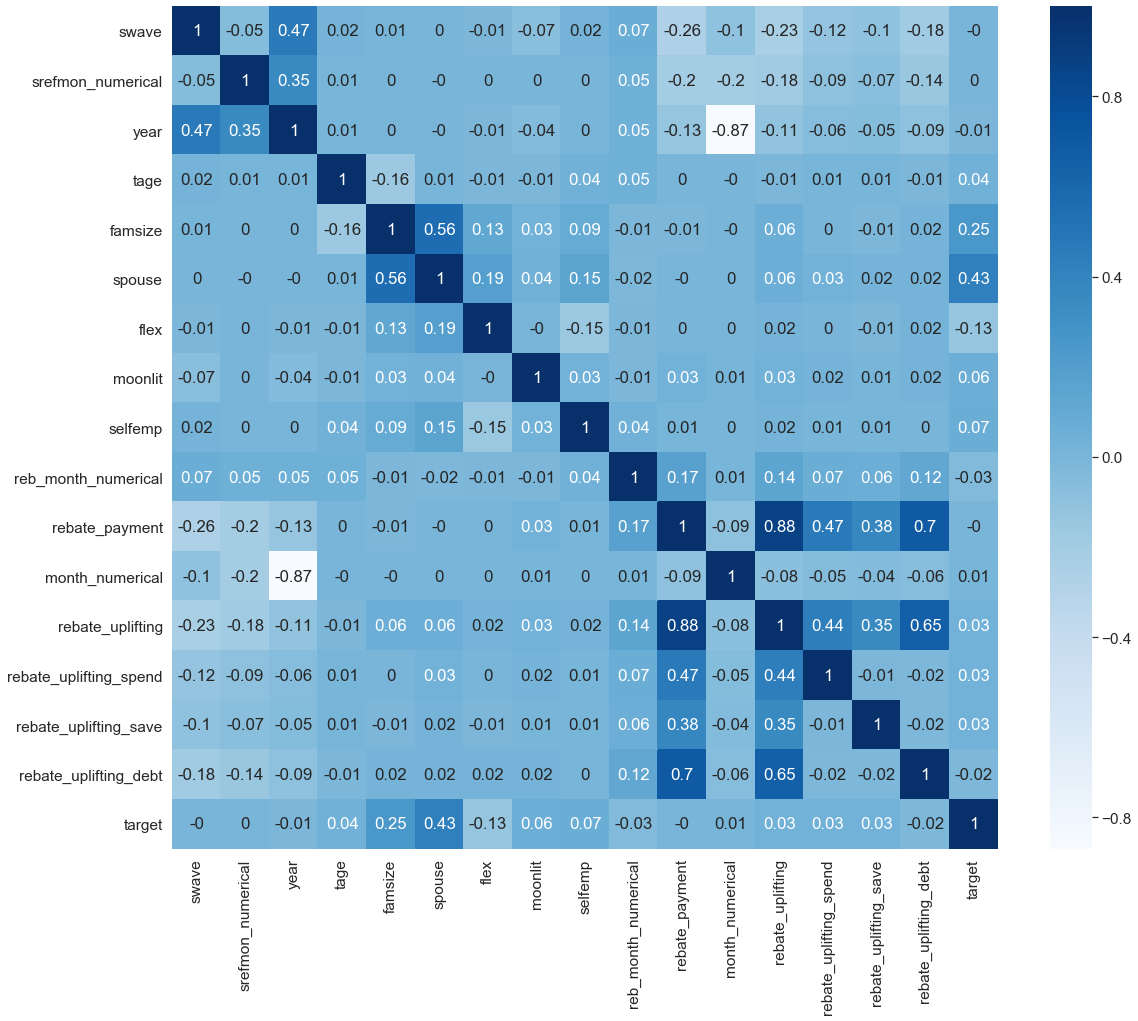

In [64]:
## Pearson Correlation Matrix


sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(18.5,15.5)) 
pear_corr = sns.heatmap(features.assign(target = target).corr().round(2),cmap = 'Blues', annot = True)
pear_corr

Print a Spearman's correlation matrix which first transforms variables into ranks and then runs the Pearson's correlation on these ranks.

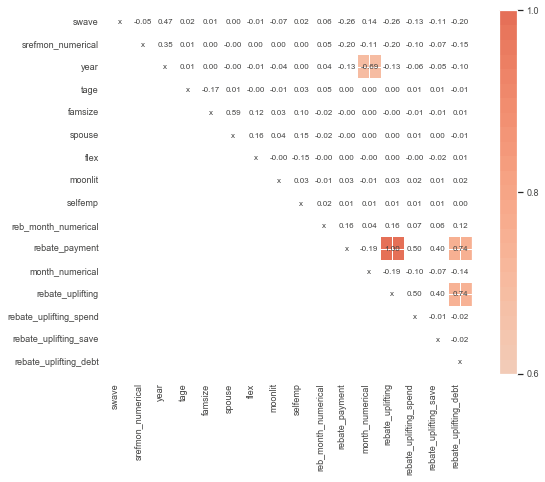

In [65]:
## Spearman Correlation Matrix


#sns.set(font_scale=25)
sns.set(font_scale=25)
fig, ax = plt.subplots(figsize=(18.5,15.5))
spear_corr = plot_corr_heatmap(features)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


Apart from small exceptions, the features used for predictions are not correlated. This will be important for the computation of the permutation feature importances, since they tend to overestimate the importance of correlated predictors.

### Impurity based default computation

In [66]:
# Plot the feature importances as a table

# I use the imp_df function that is defined in Chapter 2 of this file

default_imp = imp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
default_imp

,Feature,Control Group feature importance,Treatment Group feature importance
0,spouse,0.500021,0.395756
1,flex,0.216420,0.104657
2,famsize,0.172486,0.111732
3,tage,0.051157,0.037340
4,reb_month_numerical,0.042491,0.009695
5,selfemp,0.010315,0.008359
6,moonlit,0.005636,0.006976
7,month_numerical,0.000739,0.009863
8,swave,0.000258,0.003658
9,srefmon_numerical,0.000253,0.006894


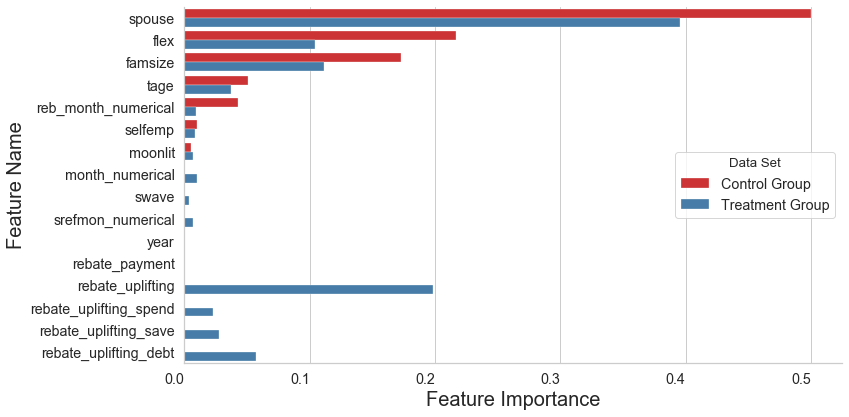

In [67]:
# Plot the feature importances as a graph
df = default_imp.copy()
title = 'Default Scikit Feature Importance'

default_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
default_plot

### Permutation based computation

What is the **difference** between the default computation of feature importances and the permutation feature importance?

The permutation feature importances are computed on a held out dataset, whereas the default scikit feature importances are measured on the complete training set. The biggest shortcoming of the default computation is the fact that it is biased towards high cardinality features. This means that features that have a high number of different unique values are given a higher significance. Another disadvantage of the impurity based default computation of the feature importance is that it does not take into account the ability of features to actually make good predictions. In contrast, random re-shuffling of values from one feature in the dataset and, hence, creating permuted datasets which are used for making predictions and measuring the accuracy can mitigate the limitations. 

As already mentioned above, one shortcoming of the permutation importance is the overestimation of correlated predictors' importances (see Strobl et al., 2008).

#### rfpimp

In [68]:
## Permutation based Feature Importances with rfpimp

# I use the perm_imp_rfpimp_df function that is defined in Chapter 2 of this file

perm_imp_rfpimp = perm_imp_rfpimp_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
perm_imp_rfpimp

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Feature,Control Group feature importance,Treatment Group feature importance
0,spouse,0.238199,0.171816
1,flex,0.073597,0.058059
2,famsize,0.026300,0.010398
3,tage,0.014950,0.007821
4,selfemp,0.002593,0.000576
5,moonlit,0.001740,0.000963
6,reb_month_numerical,0.001263,0.000695
7,month_numerical,0.000224,-0.000546
8,swave,0.000076,0.000311
9,year,0.000042,0.000000


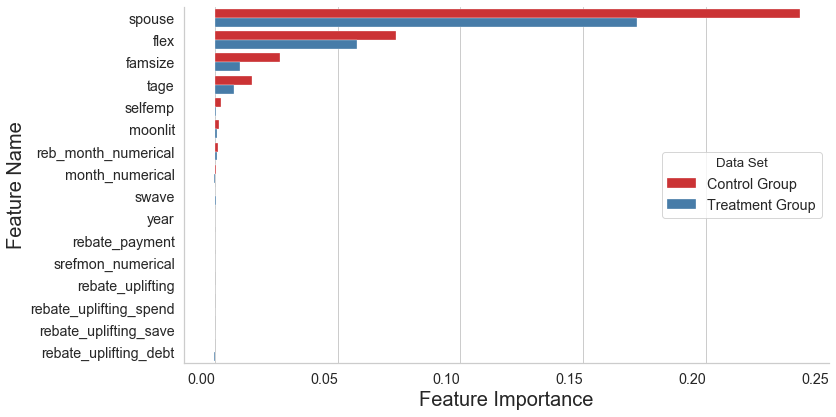

In [69]:
## Plot

df = perm_imp_rfpimp.copy()
title = 'Permutation Feature Importance using rfpimp'

perm_imp_rfpimp_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
perm_imp_rfpimp_plot

#### eli5

In [70]:
## Permutation based Feature Importances with rfpimp

# I use the perm_imp_eli5_df function that is defined in Chapter 2 of this file

perm_imp_eli5 = perm_imp_eli5_df(feature_names_model_1, feature_names_model_2, model_1, model_2, name_model_1, name_model_2)
perm_imp_eli5

,Feature,Control Group feature importance,Treatment Group feature importance
0,spouse,0.224491,0.172677
1,flex,0.076561,0.056245
2,famsize,0.030222,0.012951
3,tage,0.015259,0.006973
4,selfemp,0.002239,0.000606
5,moonlit,0.002059,0.000803
6,reb_month_numerical,0.001044,0.000656
7,month_numerical,0.000119,-0.000569
8,swave,0.000073,-0.001062
9,year,0.000063,0.000000


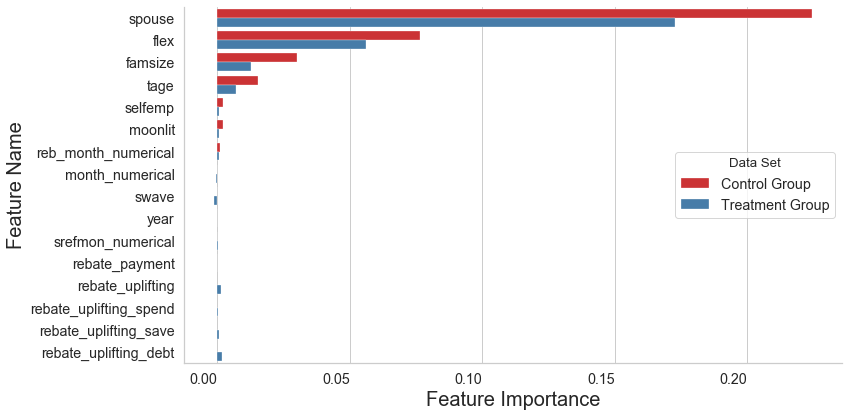

In [71]:
## Plot

df = perm_imp_eli5.copy()
title = 'Permutation Feature Importance using eli5'

perm_imp_eli5_plot = feat_imp_plot(df, name_model_1, name_model_2, title)
perm_imp_eli5_plot

### Dropping columns to measure the feature importance

In [72]:
## Drop columns to compute the Feature Importance

# I use the drop_col_feat_imp function that is defined in Chapter 2 of this file

drop_imp = drop_col_feat_imp(feature_names_model_1, feature_names_model_2, model_1, model_2)
drop_imp

,Feature,Control Group feature importance,Treatment Group feature importance
0,spouse,0.093461,0.104745
1,flex,0.041147,0.051075
2,tage,0.006733,0.018411
3,famsize,0.003956,0.020844
4,selfemp,-0.002219,0.011273
5,moonlit,-0.002473,0.011347
6,reb_month_numerical,-0.002583,0.011613
7,swave,-0.003743,0.010410
8,year,-0.003786,0.010528
9,srefmon_numerical,-0.003793,0.010453


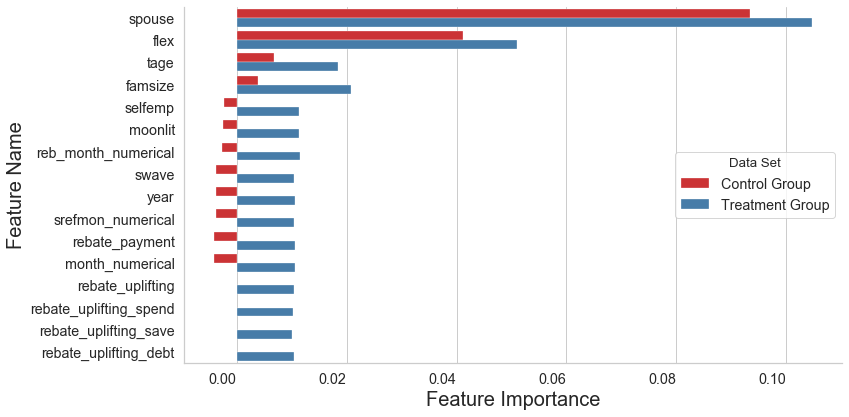

In [73]:
## Plot

df = drop_imp.copy()
title = 'Drop Column Feature Importance'

feat_imp_plot(df, name_model_1, name_model_2, title)

## Partial Dependence Plots

I provide two possible ways to produce Partial Dependence Plots: 

1) Plots for one feature only. Here I give the option to show data statistics as tables for each values of the feature. I do this for the time periods of all observation months, rebate months only and lags 1 and 2 combined

2) Plots for multiple features at the same time. By default, they are not shown here, but saved as png file in the respective folder on the computer. Again, computations are made for the time periods of all observation months, rebate months only and lags 1 and 2 combined

### Single Plot

**Cockpit for parameter setting**

In [69]:
## Change values only for the variable chosen_feature

kind = 'Percentual' # Absolute, Percentual or Marginal
chosen_feature = 'spouse' 

In [70]:
## DO NOT CHANGE ANYTHING IN THIS CELL !!! Estimation models and data inputs are chosen based on the setting above

## Features used for predicting
feature_names = rf_treatment_features_list # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.

## Selected feature for the partial dependence dataframe
pd_feature = rf_treatment_features_list.index(chosen_feature) # Do not change this row !

## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment

## Select the input data 
X_1 = np.array(result_months[rf_control_features_list])
X_2 = np.array(result_months[rf_treatment_features_list])


**CONSTRUCT DATAFRAMES FOR EACH TIME PERIOD:**

In [71]:
## Tables with Results for all observations, rebate months only and lag 1 and 2 combined. They are not shown by default, but stored

result_table_all,result_table_0,result_table_12 = pdp_df(model_1, model_2, X_1, X_2, feature_pred, pd_feature, kind)    

**SHOW THE PLOT:**

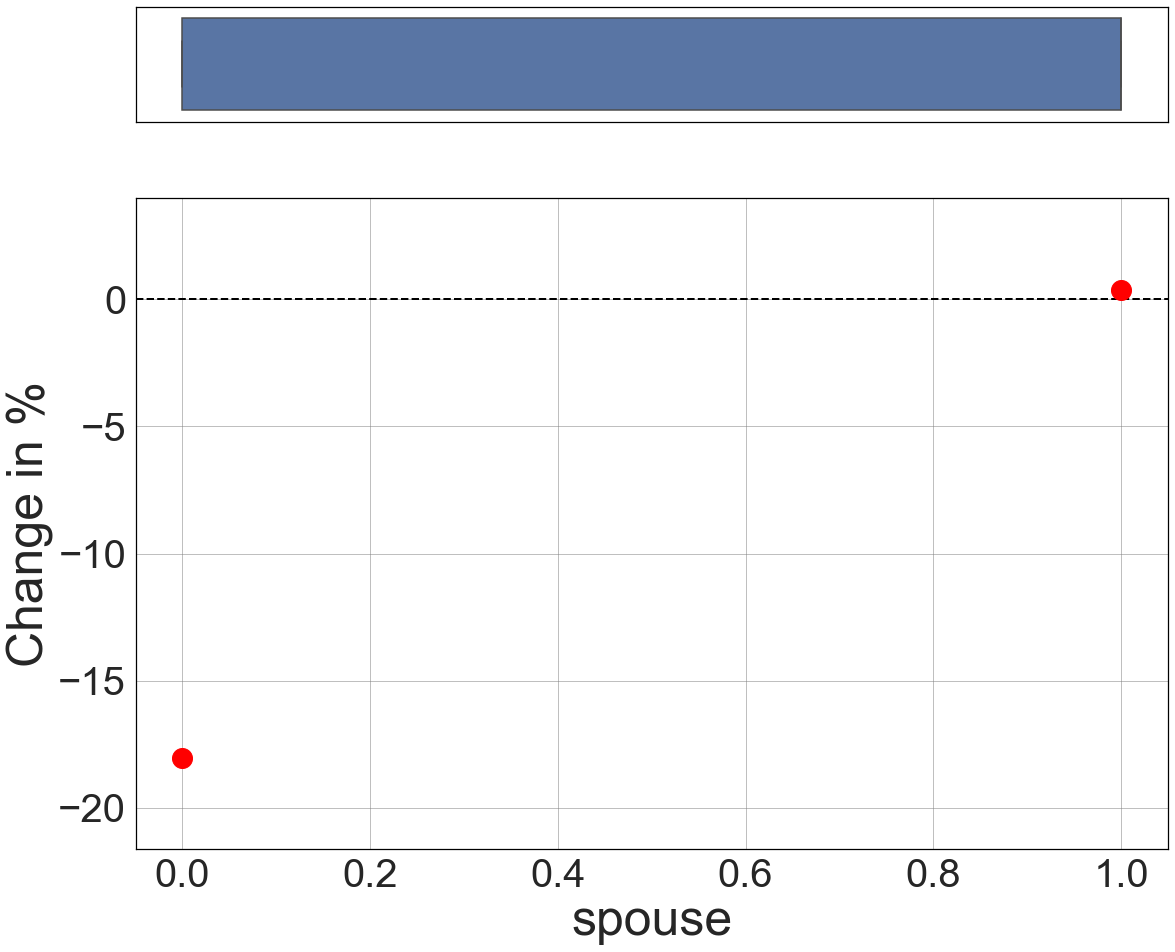

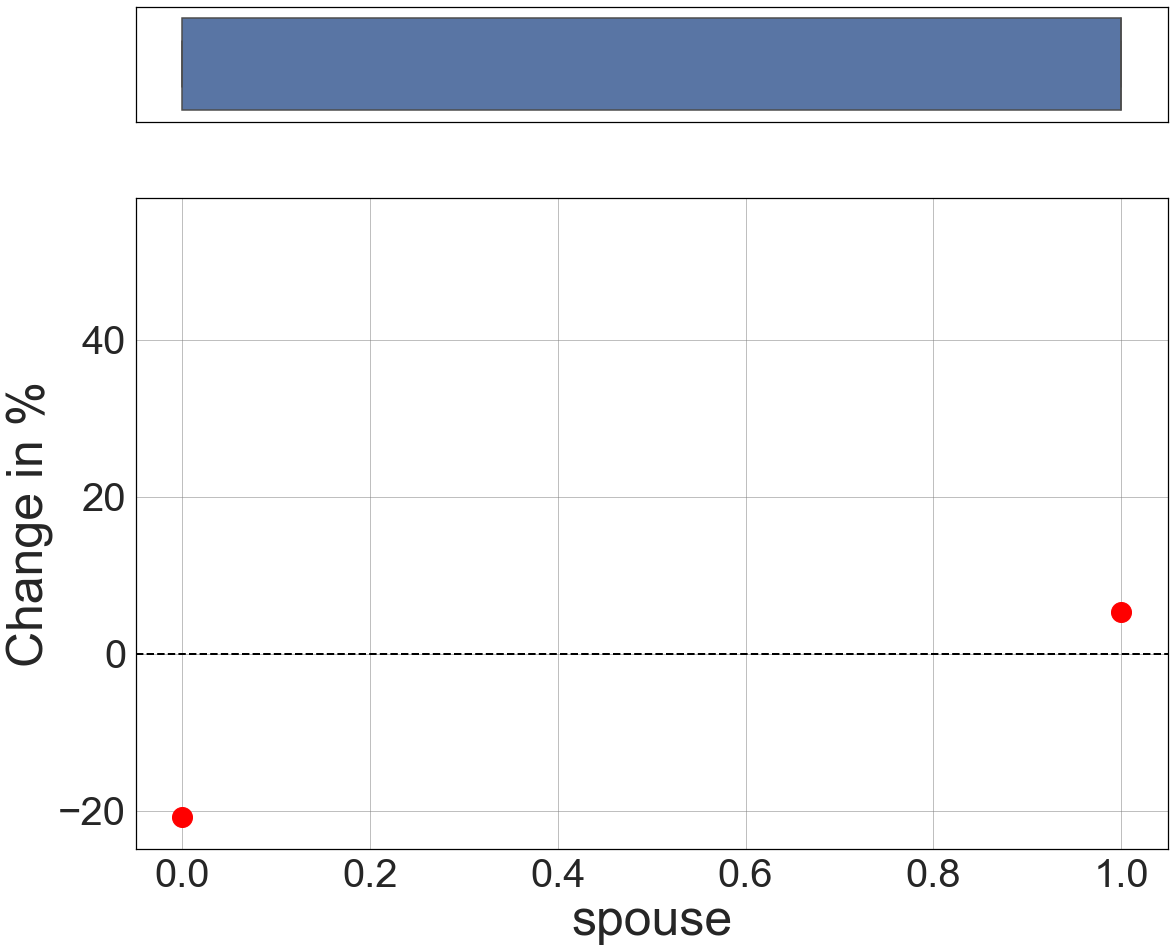

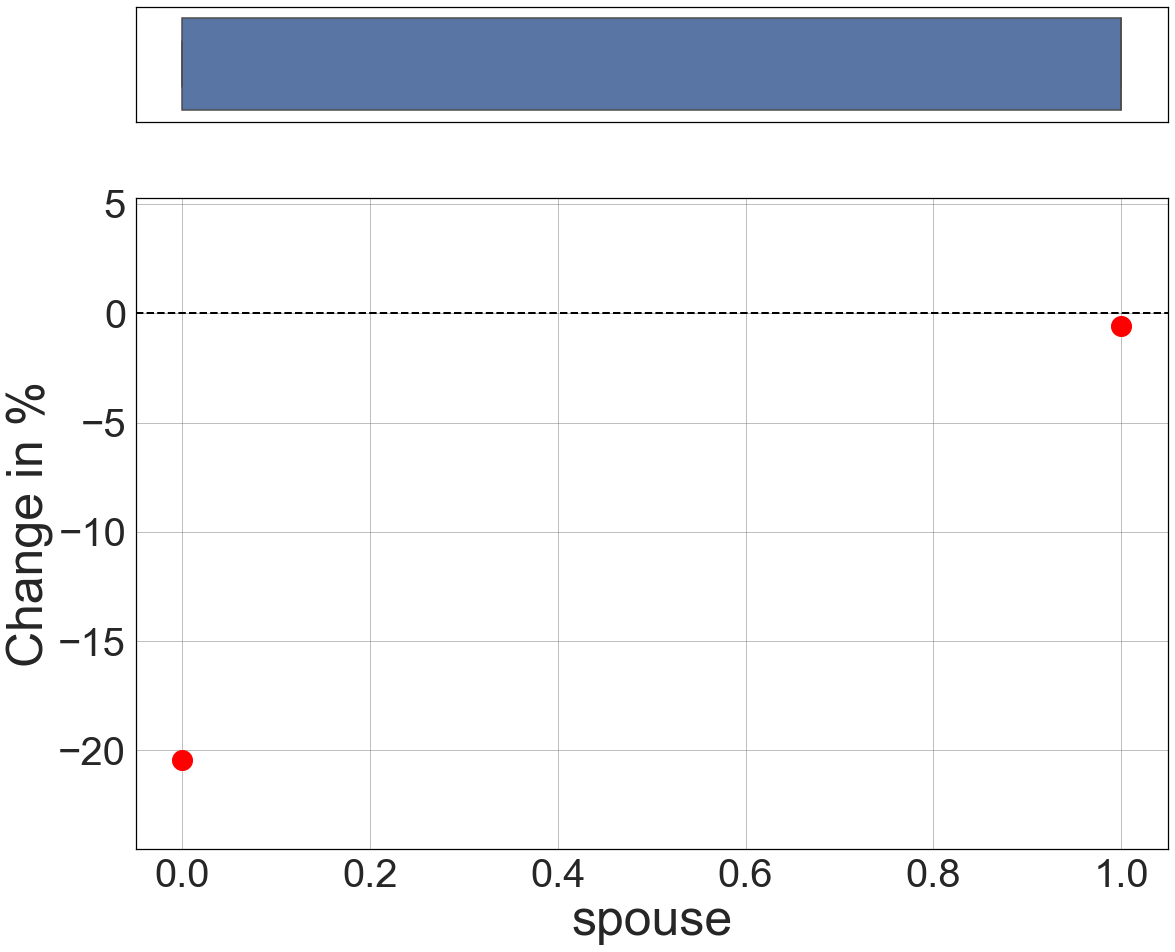

In [72]:
## Plot

# Select between median values and mean values
measure = 'Median'

pdp_plot(result_table_all, measure, kind, lags='All')
pdp_plot(result_table_0, measure, kind, lags=[0])
pdp_plot(result_table_12, measure, kind, lags=[1,2])


### Multiple Plot

The default setting is that partial dependence plots will be saved in the local folder but not displayed here in the code. This can be changed by removing the last code line under each of the three plotting commands in the code field below.

**SELECT THE FEATURES FOR THE PDP PLOTS:**

In [43]:
## Change values only for the variable chosen_feature

kind = 'Absolute' # Absolute, Percentual or Marginal
measure = 'Median' # Mean or Median
chosen_feature = ['spouse','famsize'] #rf_treatment_features_list # default setting: this means that plots for all features are produced

In [44]:
## GET THE PLOTS --- DO NOT CHANGE ANYTHING IN THIS CELL !!!
f_plot = rf_treatment_features_list # Do not change this row !

## Features used for predicting
feature_names = rf_treatment_features_list #rf_features_list_tfearn # Do not change this row ! 
feature_pred = [rf_treatment_features_list.index(x) for x in feature_names] # Do not change this row ! It assures that all the features are used for the prediction.


## Select the forecast models for the treatment and control predictions
model_1 = rf_control
model_2 = rf_treatment



##### Select the dataset for treatment and control predictions

X_1 = np.array(result_months[rf_control_features_list])
X_2 = np.array(result_months[rf_treatment_features_list])


for i, f in enumerate(chosen_feature):

    grid, y_diff_mean_all, y_diff_median_all, y_diff_mean_0, y_diff_median_0, y_diff_mean_12, y_diff_median_12, selected_lags_all, selected_lags_0, selected_lags_12  = partial_dependency(model_1, model_2, X_1, X_2, kind, feature_pred, f_plot.index(f))
    
    ### Produce the plot for all lags
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5));
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    
    
    # Add a boxplot in each part
    sns.boxplot(selected_lags_all[chosen_feature[i]], ax = ax_box);
    ax_box.set(xlabel = '');
    ax_box.spines['left'].set_color('black');
    ax_box.spines['bottom'].set_color('black');
    ax_box.spines['right'].set_color('black');
    ax_box.spines['top'].set_color('black');
    ax_box.set_facecolor('white');
    
    
    if measure == 'Mean': 
        target = y_diff_mean_all
    else: 
        target = y_diff_median_all
       
    if kind == 'Absolute': 
        unit = 'USD'
        
    else: 
        unit = '%'
        
    if kind == 'Marginal' and f == 'rebate_uplifting': 
        x = grid[20:]
        target = target[20:]

    else: 
        x=grid
        target=target
        
    if len(x) < 5: 
        ax_pdp.plot(x, target, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target)) ]) 
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
    
    
    else:
        ax_pdp.plot(x, target, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    plt.savefig(str(chosen_feature[i]) +' '+ str(measure)+' ' + str(kind) + ' Lag All.png') # plots are automatically saved
    plt.close(fig) #comment this for letting the plots be displayed
    
    
    ### Produce the plot for rebate months only
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5))
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    
    
    # Add a boxplot in each part
    sns.boxplot(selected_lags_0[chosen_feature[i]], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    if measure == 'Mean': 
        target = y_diff_mean_0
    else: 
        target = y_diff_median_0
       
    if kind == 'Absolute': 
        unit = 'USD'
        
    else: 
        unit = '%'

        
    if kind == 'Marginal' and f == 'rebate_uplifting': 
        x = grid[20:]
        target = target[20:]

    else: 
        x=grid
        target=target
        
    if len(x) < 5: 
        ax_pdp.plot(x, target, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(10*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    
    else:
        ax_pdp.plot(x, target, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    plt.savefig(str(chosen_feature[i]) +' '+ str(measure)+' ' + str(kind) + ' Lag [0].png') # plots are automatically saved
    plt.close(fig) #comment this for letting the plots be displayed
    

    
    ### Produce the plot for lags 1 and 2
    
    # Cut the figure window into two parts
    fig, (ax_box, ax_pdp) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5))
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)    
    
    # Add a boxplot in each part
    sns.boxplot(selected_lags_12[chosen_feature[i]], ax = ax_box)
    ax_box.set(xlabel = '')
    ax_box.spines['left'].set_color('black')
    ax_box.spines['bottom'].set_color('black')
    ax_box.spines['right'].set_color('black')
    ax_box.spines['top'].set_color('black')
    ax_box.set_facecolor('white')
    
    if measure == 'Mean': 
        target = y_diff_mean_12
    else: 
        target = y_diff_median_12
       
    if kind == 'Absolute': 
        unit = 'USD'
        
    else: 
        unit = '%'

        
    if kind == 'Marginal' and f == 'rebate_uplifting': 
        x = grid[20:] #exclude very small rebate values in the plot
        target = target[20:] #exclude very small rebate values in the plot

    else: 
        x=grid
        target=target
        
    if len(x) < 5: 
        ax_pdp.plot(x, target, 'o', color = 'red', markersize = 20)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05,  min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))]) 
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    
    else:
        ax_pdp.plot(x, target, '-', color = 'red', linewidth = 2.5)
        ax_pdp.hlines(0, xmin = min(x)-0.05, xmax= max(x)+0.05, colors='black', linestyles='--',linewidth=2, alpha=1)
        ax_pdp.axis([min(x)-0.05, max(x)+0.05, min(target)-abs(0.2*min(target)), max(target)+0.2*abs(max(target))])
        ax_pdp.set(xlabel = chosen_feature[i], ylabel = 'Change in '+ str(unit))
        ax_pdp.spines['left'].set_color('black')
        ax_pdp.spines['bottom'].set_color('black')
        ax_pdp.spines['right'].set_color('black')
        ax_pdp.spines['top'].set_color('black')
        ax_pdp.set_facecolor('white')
        ax_pdp.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
        ax_pdp.xaxis.label.set_fontsize(50)
        ax_pdp.yaxis.label.set_fontsize(50)
        ax_pdp.tick_params(labelsize=40)
        
    plt.savefig(str(chosen_feature[i]) +' '+ str(measure)+' ' + str(kind) + ' Lag [1, 2].png')  # plots are automatically saved
    plt.close(fig) #comment this for letting the plots be displayed

## Distribution of Labor Income Responses

**Cockpit for Parameter Selection**

In [80]:
#### Income Distribution
kind = 'Absolute' # Absolute, Percentual or Marginal
lag = [0] # 'All' selects all observation months in the data set, whereas a value like 0, 1 or 2 selects lag 0, lag 1 or lag 2 respectively

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


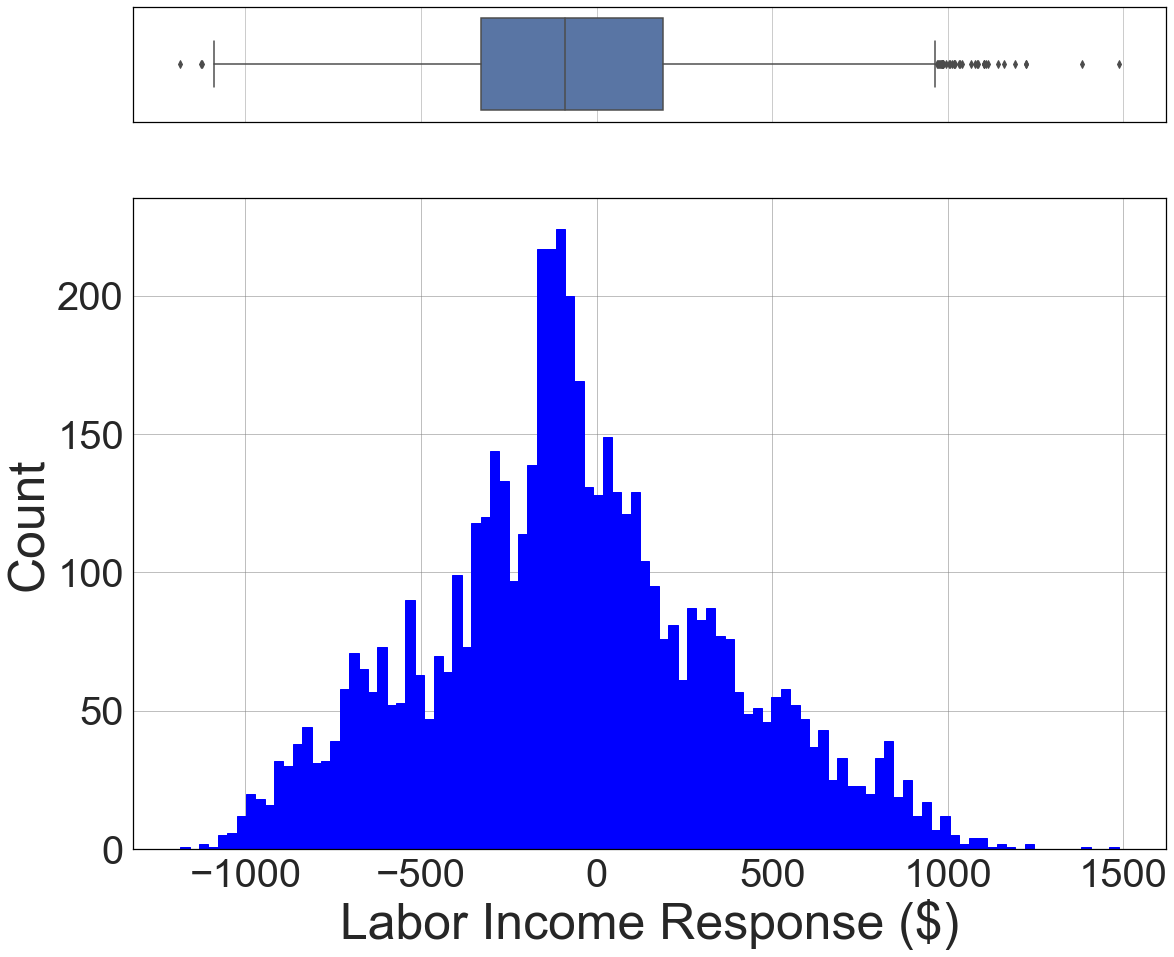

In [81]:
# Histogram Plot for Rebate Responses Distribution
selected_lags = lag_function(lag,frame=result_months)

if kind == 'Absolute':
    responses = selected_lags['rf_labor_income_diff']
    unit = '$'
elif kind == 'Percentual': 
    responses = selected_lags['rf_perc_labor_income_diff'][(selected_lags['rf_perc_labor_income_diff'] > selected_lags['rf_perc_labor_income_diff'].quantile(0.01)) & (selected_lags['rf_perc_labor_income_diff'] < selected_lags['rf_perc_labor_income_diff'].quantile(0.99))]*100
    unit = '%'
else:
    responses = selected_lags['rf_marg_labor_income_diff'][(selected_lags['rf_marg_labor_income_diff'] > selected_lags['rf_marg_labor_income_diff'].quantile(0.01)) & (selected_lags['rf_marg_labor_income_diff'] < selected_lags['rf_marg_labor_income_diff'].quantile(0.99))]*100
    unit = '%'

    
# Cut the figure window into two parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize=(18.5, 15.5))

# Add a graph in each part
sns.boxplot(responses, ax = ax_box)
ax_box.set(xlabel = '')
ax_box.spines['left'].set_color('black')
ax_box.spines['bottom'].set_color('black')
ax_box.spines['right'].set_color('black')
ax_box.spines['top'].set_color('black')
ax_box.set_facecolor('white')
  
count, response_bins, bars = ax_hist.hist(responses, bins=100, color='blue', edgecolor='blue')
ax_hist.set(xlabel = 'Labor Income Response (' + str(unit) +  ')', ylabel = 'Count')
ax_hist.spines['left'].set_color('black')
ax_hist.spines['bottom'].set_color('black')
ax_hist.spines['right'].set_color('black')
ax_hist.spines['top'].set_color('black')
ax_hist.set_facecolor('white')
ax_hist.grid(color='grey', linestyle='-', linewidth=0.5, alpha=1)
ax_hist.xaxis.label.set_fontsize(50)
ax_hist.yaxis.label.set_fontsize(50)
ax_hist.tick_params(labelsize=40)

plt.savefig(str(kind) + ' Labor Income Response Distribution in Lag ' + str(lag) + '.png')

## Labor Income Quantile Distribution

**IDEA:**

Here, I want to look at the different labor income reactions conditional on the households' individual income. Following Powell, I am interested in finding out if there are substantial differences in labor income changes across different household labor income levels. 

On the x-axis, I will have all the different monthly labor incomes for all households (optionally, one can also take the mean labor income over the 8 months for every household and thus have only one x value for each household). On the y-axis, I will picture the different labor income effects.

**Select months:**

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In the graph below, the following lags are considered: [0]


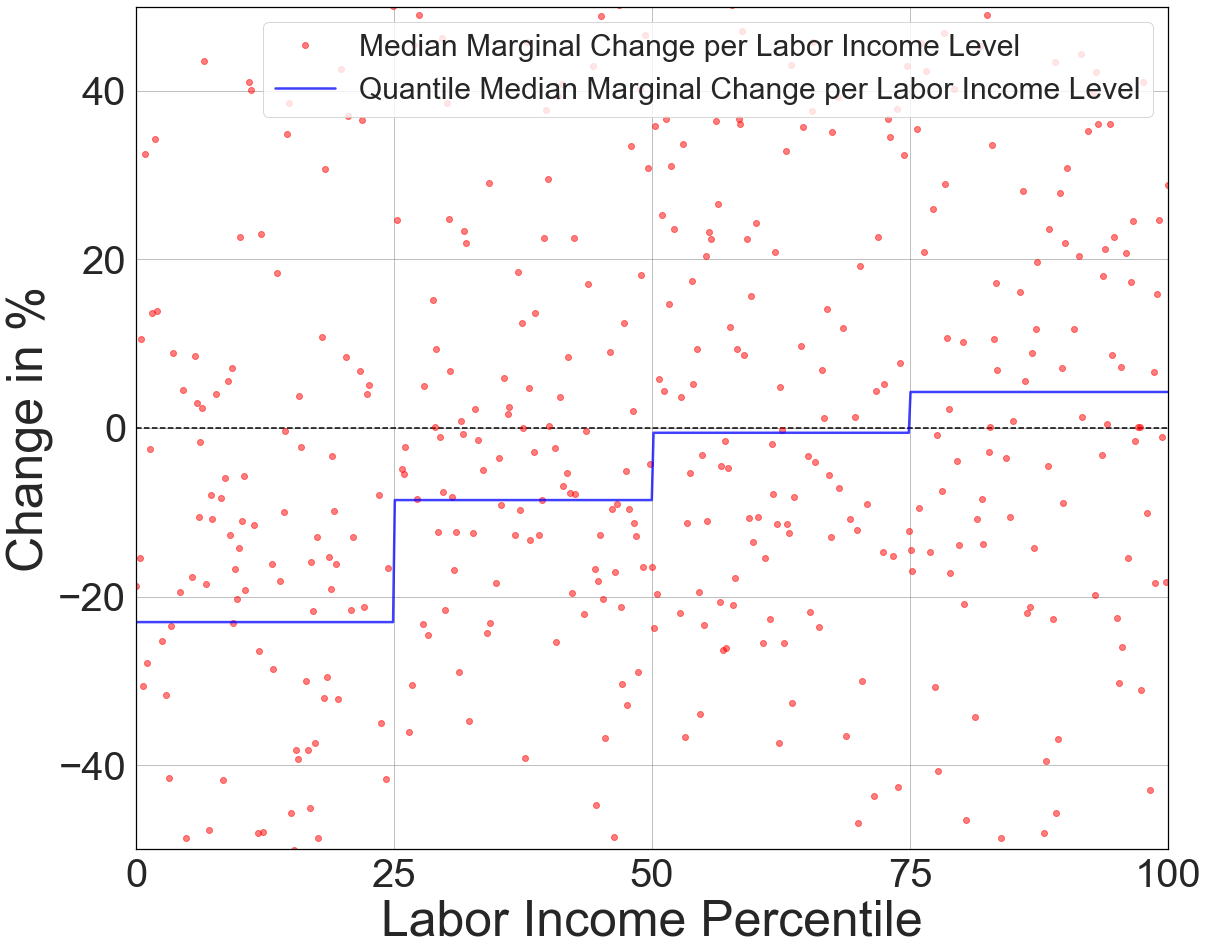

,Median Marginal Change in Labor Income (%)
Quantile,
1,-23.033592
2,-8.551927
3,-0.565027
4,4.276584


In [78]:
## Select data to look at in detail

## I only show the second plot in my thesis

## I observe strong variations in the quantile reactions when I choose different lags. Therefore, I am not sure how 
## reliable these calculations are. 

measure = 'Median'
kind = 'Marginal'
lag = [0]
nth_value = 5 # every nth value will be plotted in the graph
n_quantile = 4 # select the number of quantiles
plot1 = False # True for plotting the first graph
plot2 = True # True for plotting the second graph


selected_lags = lag_function(lag,frame=result_months)

source = selected_lags
print('In the graph below, the following lags are considered: ' + str(lag))


## Graphical Data Statistics

quantile_plot,quantile_statistics = mean_percentile(source, measure, kind, nth_value, n_quantile, plot1, plot2)
quantile_plot

In [79]:
## Quantile Result Statistics in more detail
print('The quantile results calculation is based on estimations for ' + str(len(quantile_statistics)) + ' different income levels.')
quantile_statistics

The quantile results calculation is based on estimations for 2972 different income levels.


,Reported Monthly Labor Income,Percentile,Median Marginal Change per Labor Income Level,Median Marginal Change Quantiles
0,1100,0.000000,-18.784345,-23.033592
1,1104,0.033659,-59.754667,-23.033592
2,1106,0.067317,12.002034,-23.033592
3,1117,0.100976,2.312011,-23.033592
4,1120,0.134635,-42.046408,-23.033592
5,1130,0.168294,-53.059476,-23.033592
6,1131,0.201952,-3.959342,-23.033592
7,1134,0.235611,33.212838,-23.033592
8,1137,0.269270,-49.551729,-23.033592
9,1150,0.302928,12.974306,-23.033592


# End